In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time 
from tqdm import tqdm
import pandas as pd

In [16]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

In [17]:
def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)

In [18]:
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model


In [19]:
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [20]:
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0

In [21]:
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)

In [22]:
def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    ##Pre Training the neural network
    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    model.fit(stock_paths[:, N].reshape(-1, 1), payoff_T.reshape(-1, 1), epochs=1000, batch_size=int(0.1 * sample_size), verbose=0)
    ## Pre Training completed   
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = create_shallow_NN(1, no_hidden_units)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    ## Train the model  
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)
    
    # Test the model
    y_hat_val = model.predict(X_test)
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    #plt.scatter(X_train, y_train, label='Actual')
    # Sort X_train and y_hat for a smoother line plot
    #sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
    #X_train_sorted = X_train[sorted_indices]
    #y_hat_sorted = y_hat_val[sorted_indices]
    #plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
    #plt.show()
    
    ## Get the weights of the model
    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    ## Calculate the option price at the previous monitoring dates
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose =0)
        
        y_hat = model.predict(X_test)
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append(model.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
        
    return option_price[0, 0], weights, errors

    

In [23]:
S0 = 50                                 # Initial stock price
K = 50                                  # Strike price
mu = 0.06                               # Risk free rate
sigma = 0.2                             # Volatility
T = 1                                   # Time to maturity
N = 6                                   # Number of monitoring dates
hidden_units = 4                        # Number of hidden units in the neural network
ler_rate = 0.01                         # Learning rate
M = 5000                                # Number of sample paths


In [24]:
option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', 4, ler_rate)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


Text(0, 0.5, 'MSE of error')

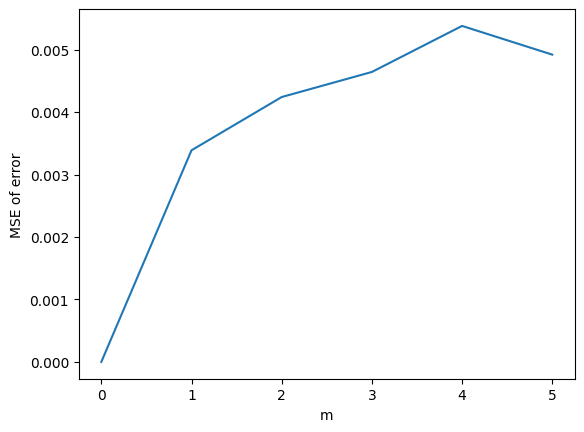

In [25]:
plt.plot(error)
plt.xlabel('m')
plt.ylabel('MSE of error')

In [26]:
hidden_units = list([4, 8, 16, 32])
option_prices = []
times = []
errors = []

for no_hidden_units in tqdm(hidden_units):
    start_time = time.time()
    option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', no_hidden_units, ler_rate)
    end_time = time.time()
    times.append(end_time - start_time)
    option_prices.append(option_price)
    errors.append(error) 

  0%|          | 0/4 [00:00<?, ?it/s]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step


 25%|██▌       | 1/4 [01:07<03:23, 67.86s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 50%|█████     | 2/4 [02:16<02:16, 68.49s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


 75%|███████▌  | 3/4 [03:56<01:22, 82.73s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 4/4 [05:46<00:00, 86.52s/it]


### Optimal Hidden Units

In [27]:
hidden_units = [4, 8, 16, 32]
option_prices = []
times = []
errors = []
confidence_intervals = []

# Number of simulations per hidden unit configuration
n_simulations = 10  # Adjust based on computational resources

for no_hidden_units in tqdm(hidden_units):
    option_prices_temp = []
    times_temp = []
    errors_temp = []

    for _ in tqdm(range(n_simulations)):
        start_time = time.time()
        option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', no_hidden_units, ler_rate)
        end_time = time.time()

        times_temp.append(end_time - start_time)
        option_prices_temp.append(option_price)
        errors_temp.append(error)
    
    # Calculate mean and confidence interval
    mean_price = np.mean(option_prices_temp)
    std_dev_price = np.std(option_prices_temp)
    ci = 1.96 * std_dev_price / np.sqrt(n_simulations)  # 95% confidence level

    # Store results
    times.append(np.mean(times_temp))
    option_prices.append(mean_price)
    errors.append(np.mean(errors_temp))
    confidence_intervals.append(ci)



  0%|          | 0/4 [00:00<?, ?it/s]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


 25%|██▌       | 1/4 [11:29<34:28, 689.64s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


 50%|█████     | 2/4 [24:12<24:25, 732.96s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 75%|███████▌  | 3/4 [36:26<12:13, 733.26s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


100%|██████████| 4/4 [52:05<00:00, 781.41s/it]


In [28]:
option_prices = np.array(option_prices)
times = np.array(times)
errors = np.array(errors)

In [29]:
option_prices

array([3.40094676, 2.75306259, 2.76230678, 2.7565168 ])

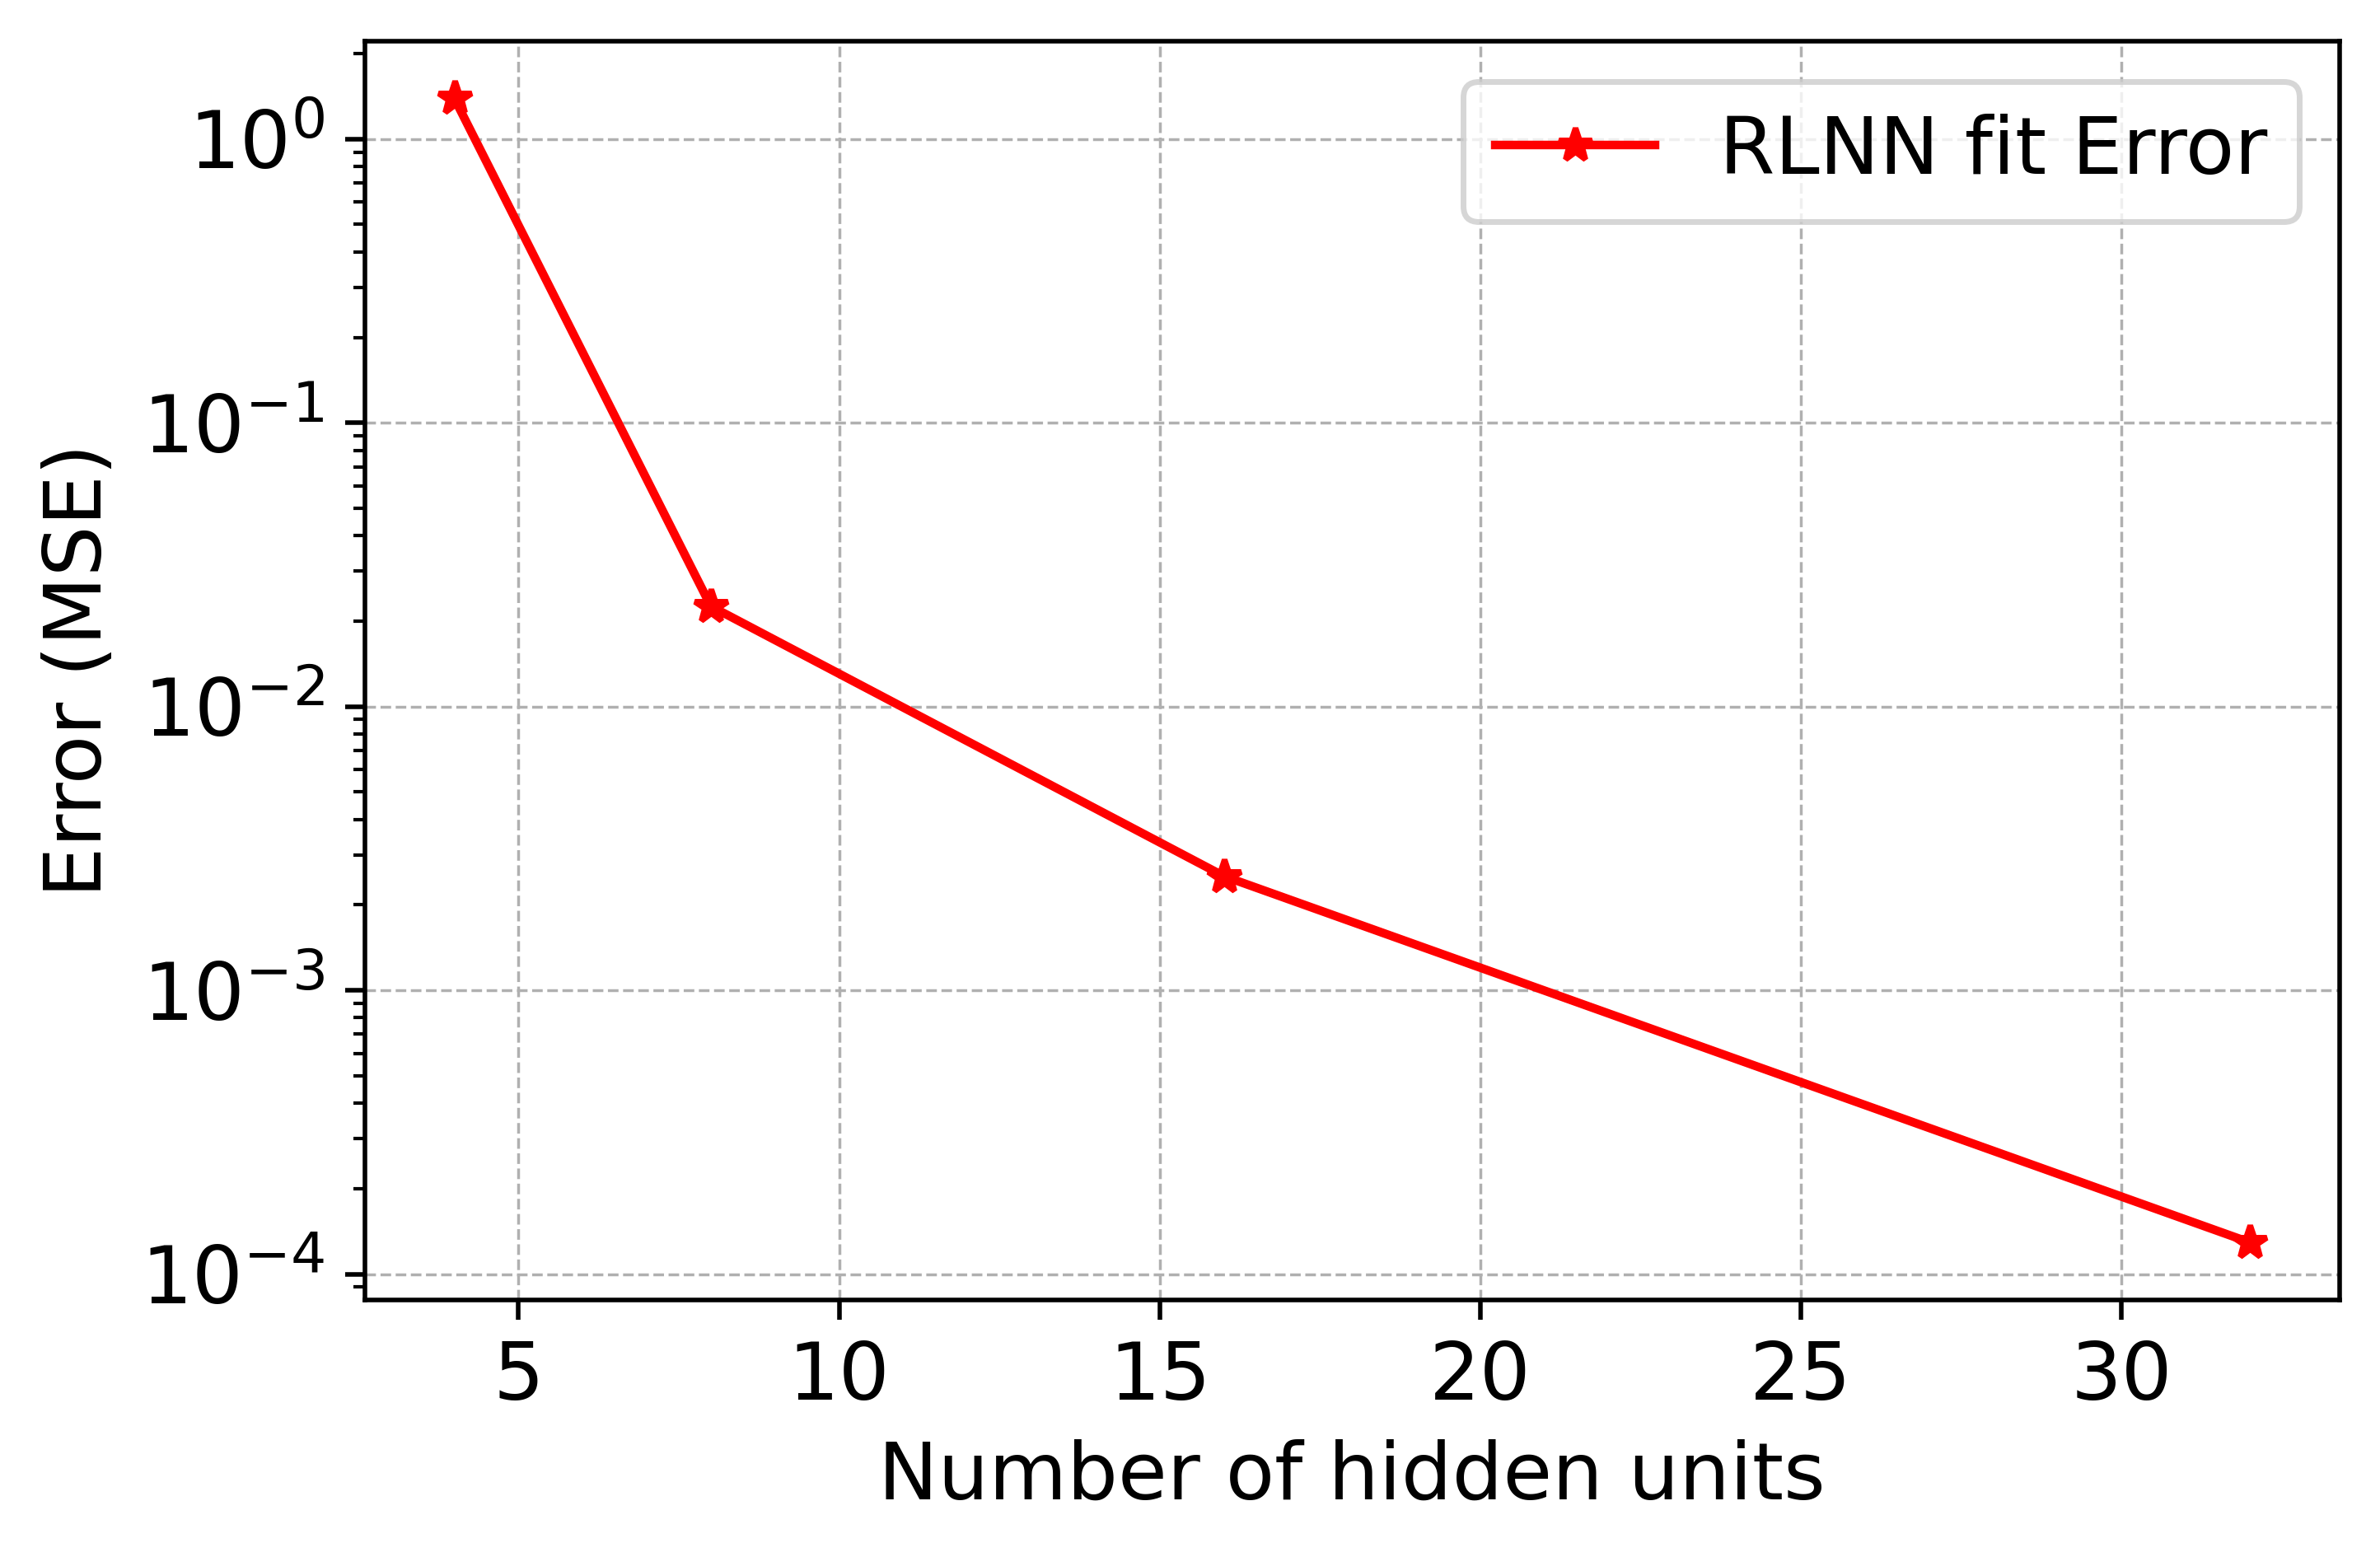

In [30]:
plt.figure(dpi=500, figsize=(6, 4))
plt.rc('font', size=14)
plt.plot(hidden_units[:], errors[:],label='RLNN fit Error', marker='*', color='r')
plt.yscale('log')
plt.xlabel('Number of hidden units')
plt.ylabel('Error (MSE)')
# Add grid and legend
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.savefig('Error_vs_Hidden_units.png')

### Performance (time) Vs Hidden Units

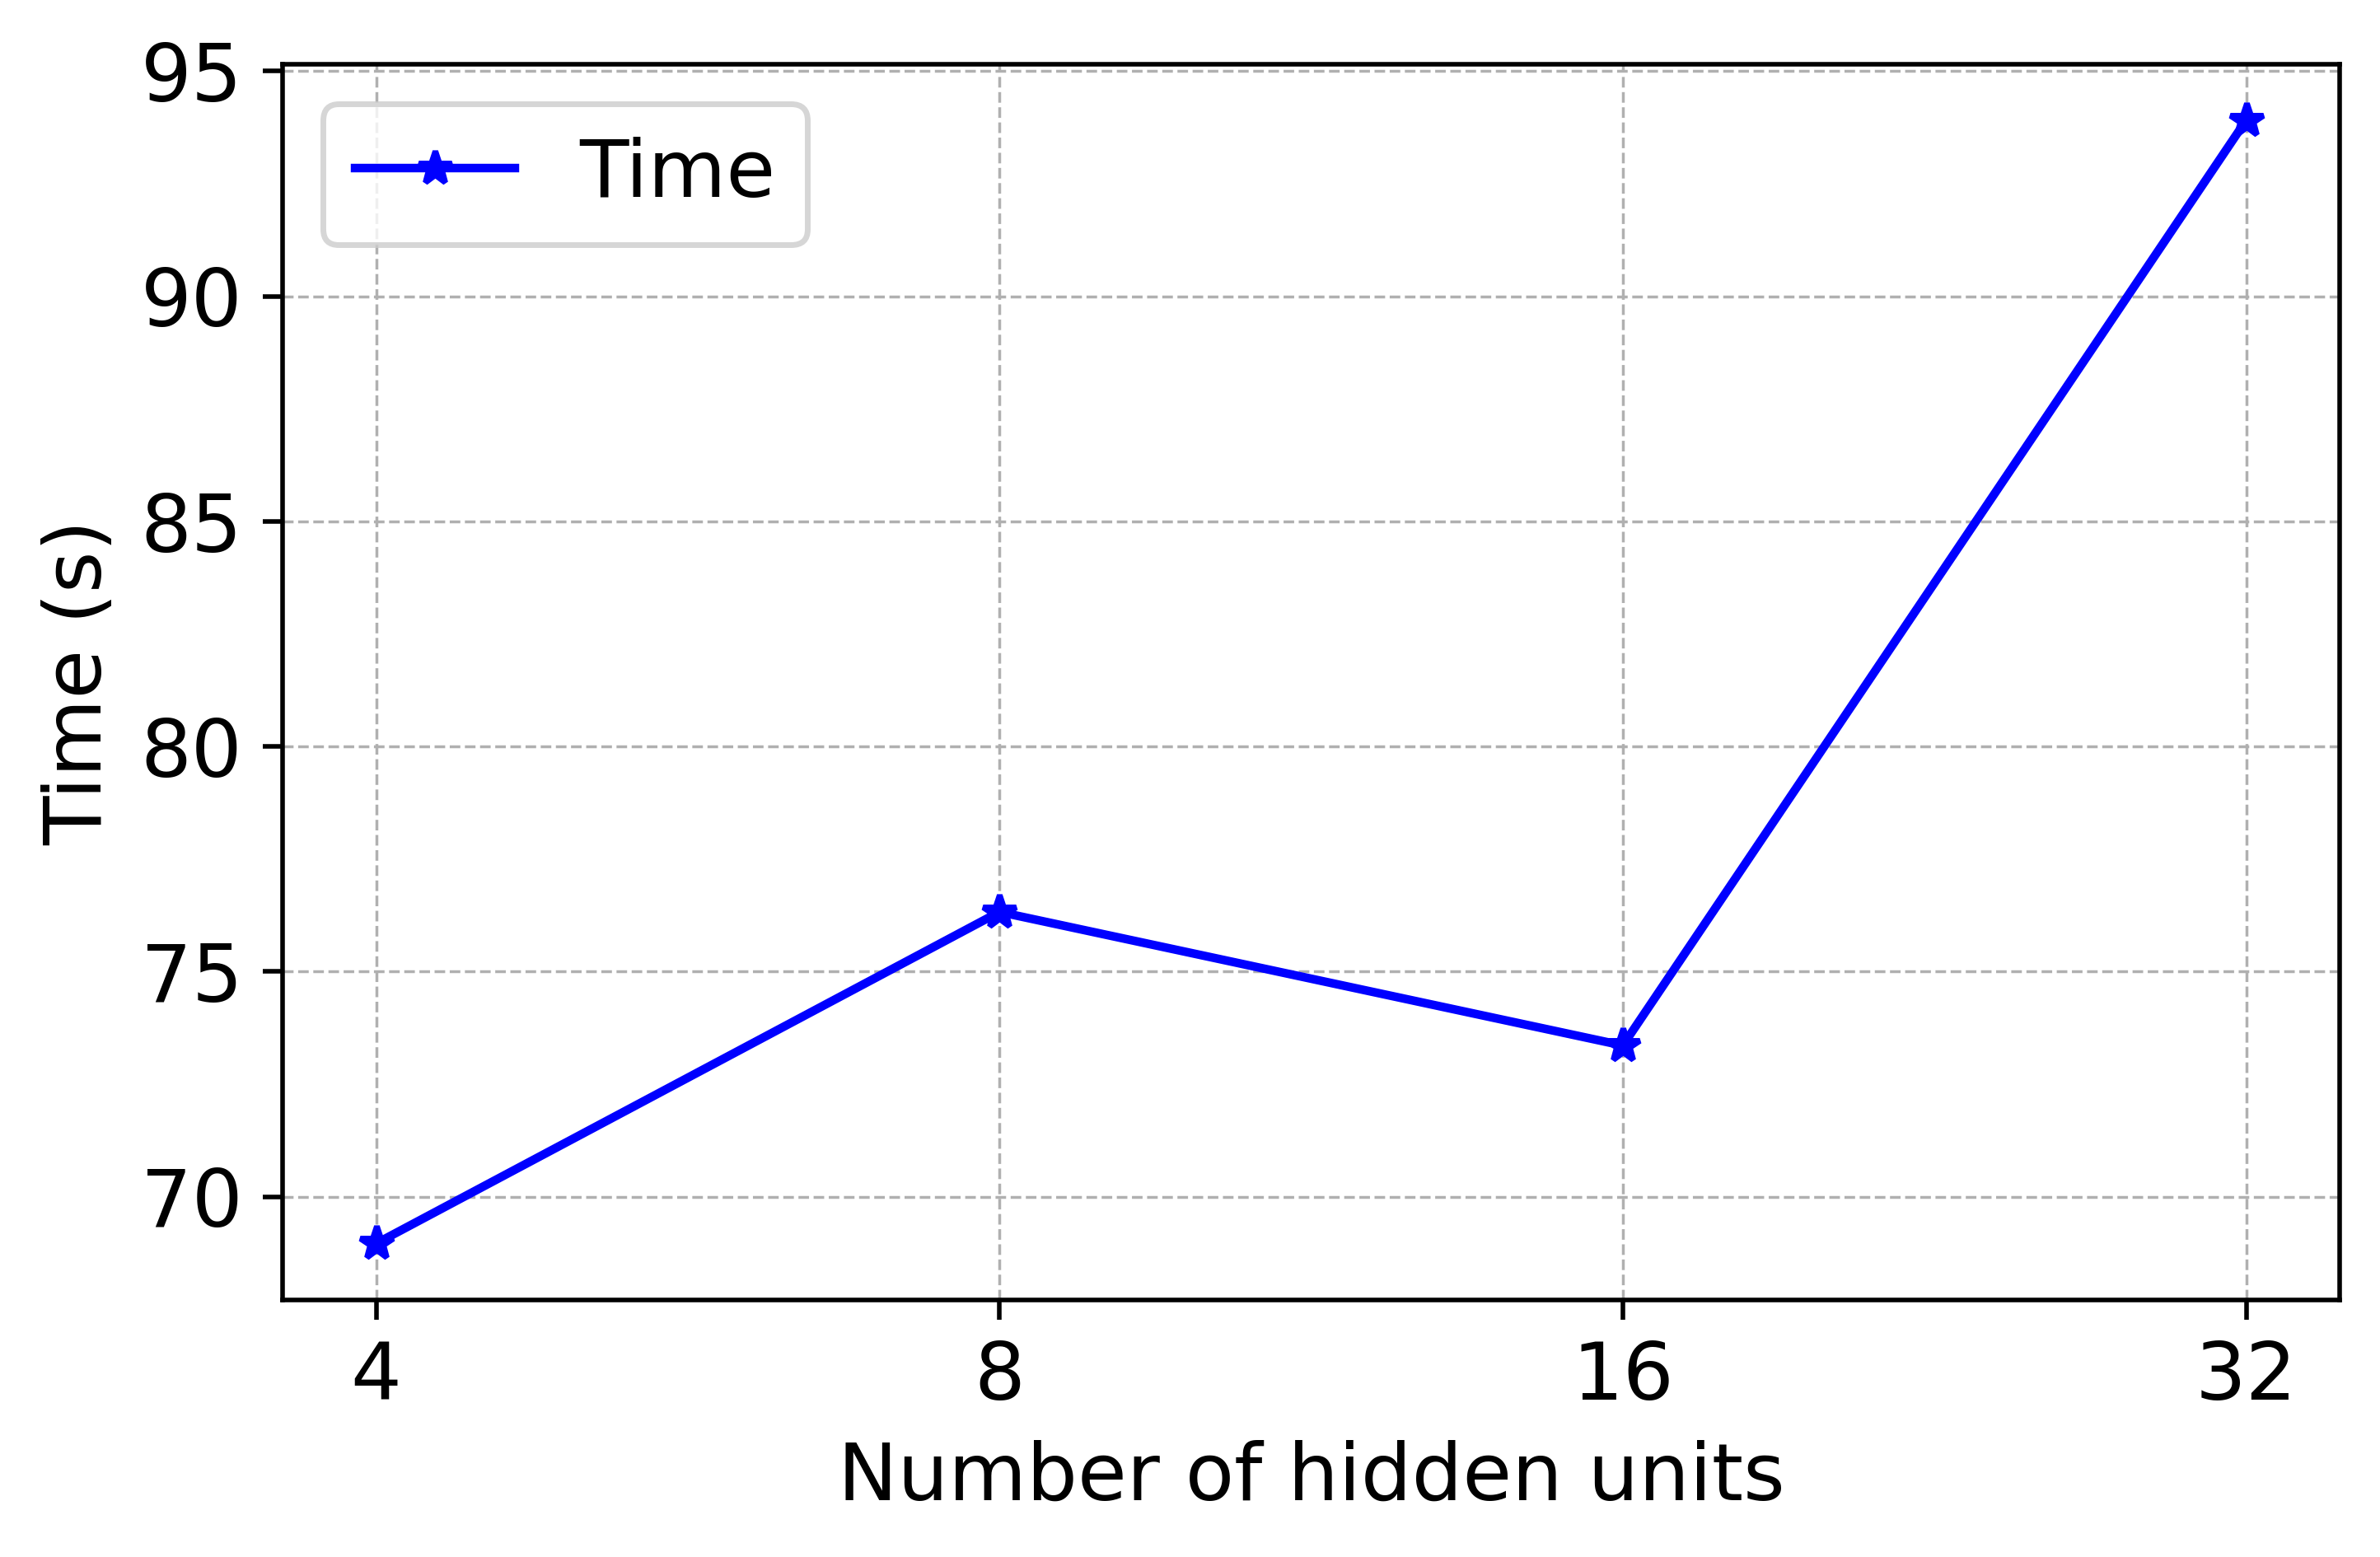

In [31]:
# Create the plot
plt.figure(dpi=500, figsize=(6, 4))
plt.rc('font', size=14)
plt.plot(hidden_units, times, label='Time', marker='*', color='b')
plt.xscale('log', base=2)
# Customize ticks to show 2, 4, 8, etc.
ticks = hidden_units
plt.xticks(ticks, labels=[str(tick) for tick in ticks])

# Label the axes
plt.xlabel('Number of hidden units')
plt.ylabel('Time (s)')

# Add grid and legend
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('Time_vs_Hidden_units.png')
plt.show()

In [32]:
def bermudan_option_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="call"):
    """
    Price a Bermudan option using the Binomial Tree method.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree
    - exercise_dates: List of times (as fractions of T) at which early exercise is allowed
    - option_type: "call" for call option, "put" for put option
    
    Returns:
    - The option price
    """
    
    # Calculate parameters for binomial tree
    dt = T / N  # Time increment
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    
    # Initialize asset prices at maturity
    stock_prices = np.zeros(N + 1)
    stock_prices[0] = S0 * d**N
    for i in range(1, N + 1):
        stock_prices[i] = stock_prices[i - 1] * u / d

    # Initialize option values at maturity
    option_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
    #print(option_values, stock_prices)
    
    # Backward induction for Bermudan option pricing
    for i in range(N - 1, -1, -1):
        stock_prices = stock_prices[:-1] * u  # Step back in time
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])
        
        # Apply early exercise at specified exercise dates
        if i * dt in exercise_dates:
            #print(f"Applying early exercise at time {i * dt}")
            exercise_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
            #print(exercise_values, stock_prices, K)
            option_values = np.maximum(option_values, exercise_values)

    return option_values[0]

In [33]:
n_steps = 6 * 8
exercise_dates = np.arange(1/6, 1.00001, 1/6)
binomial_price = bermudan_option_binomial(S0, K, T, mu, sigma,  n_steps, exercise_dates, 'put')

In [34]:
hidden_units = [4, 8, 16, 32]

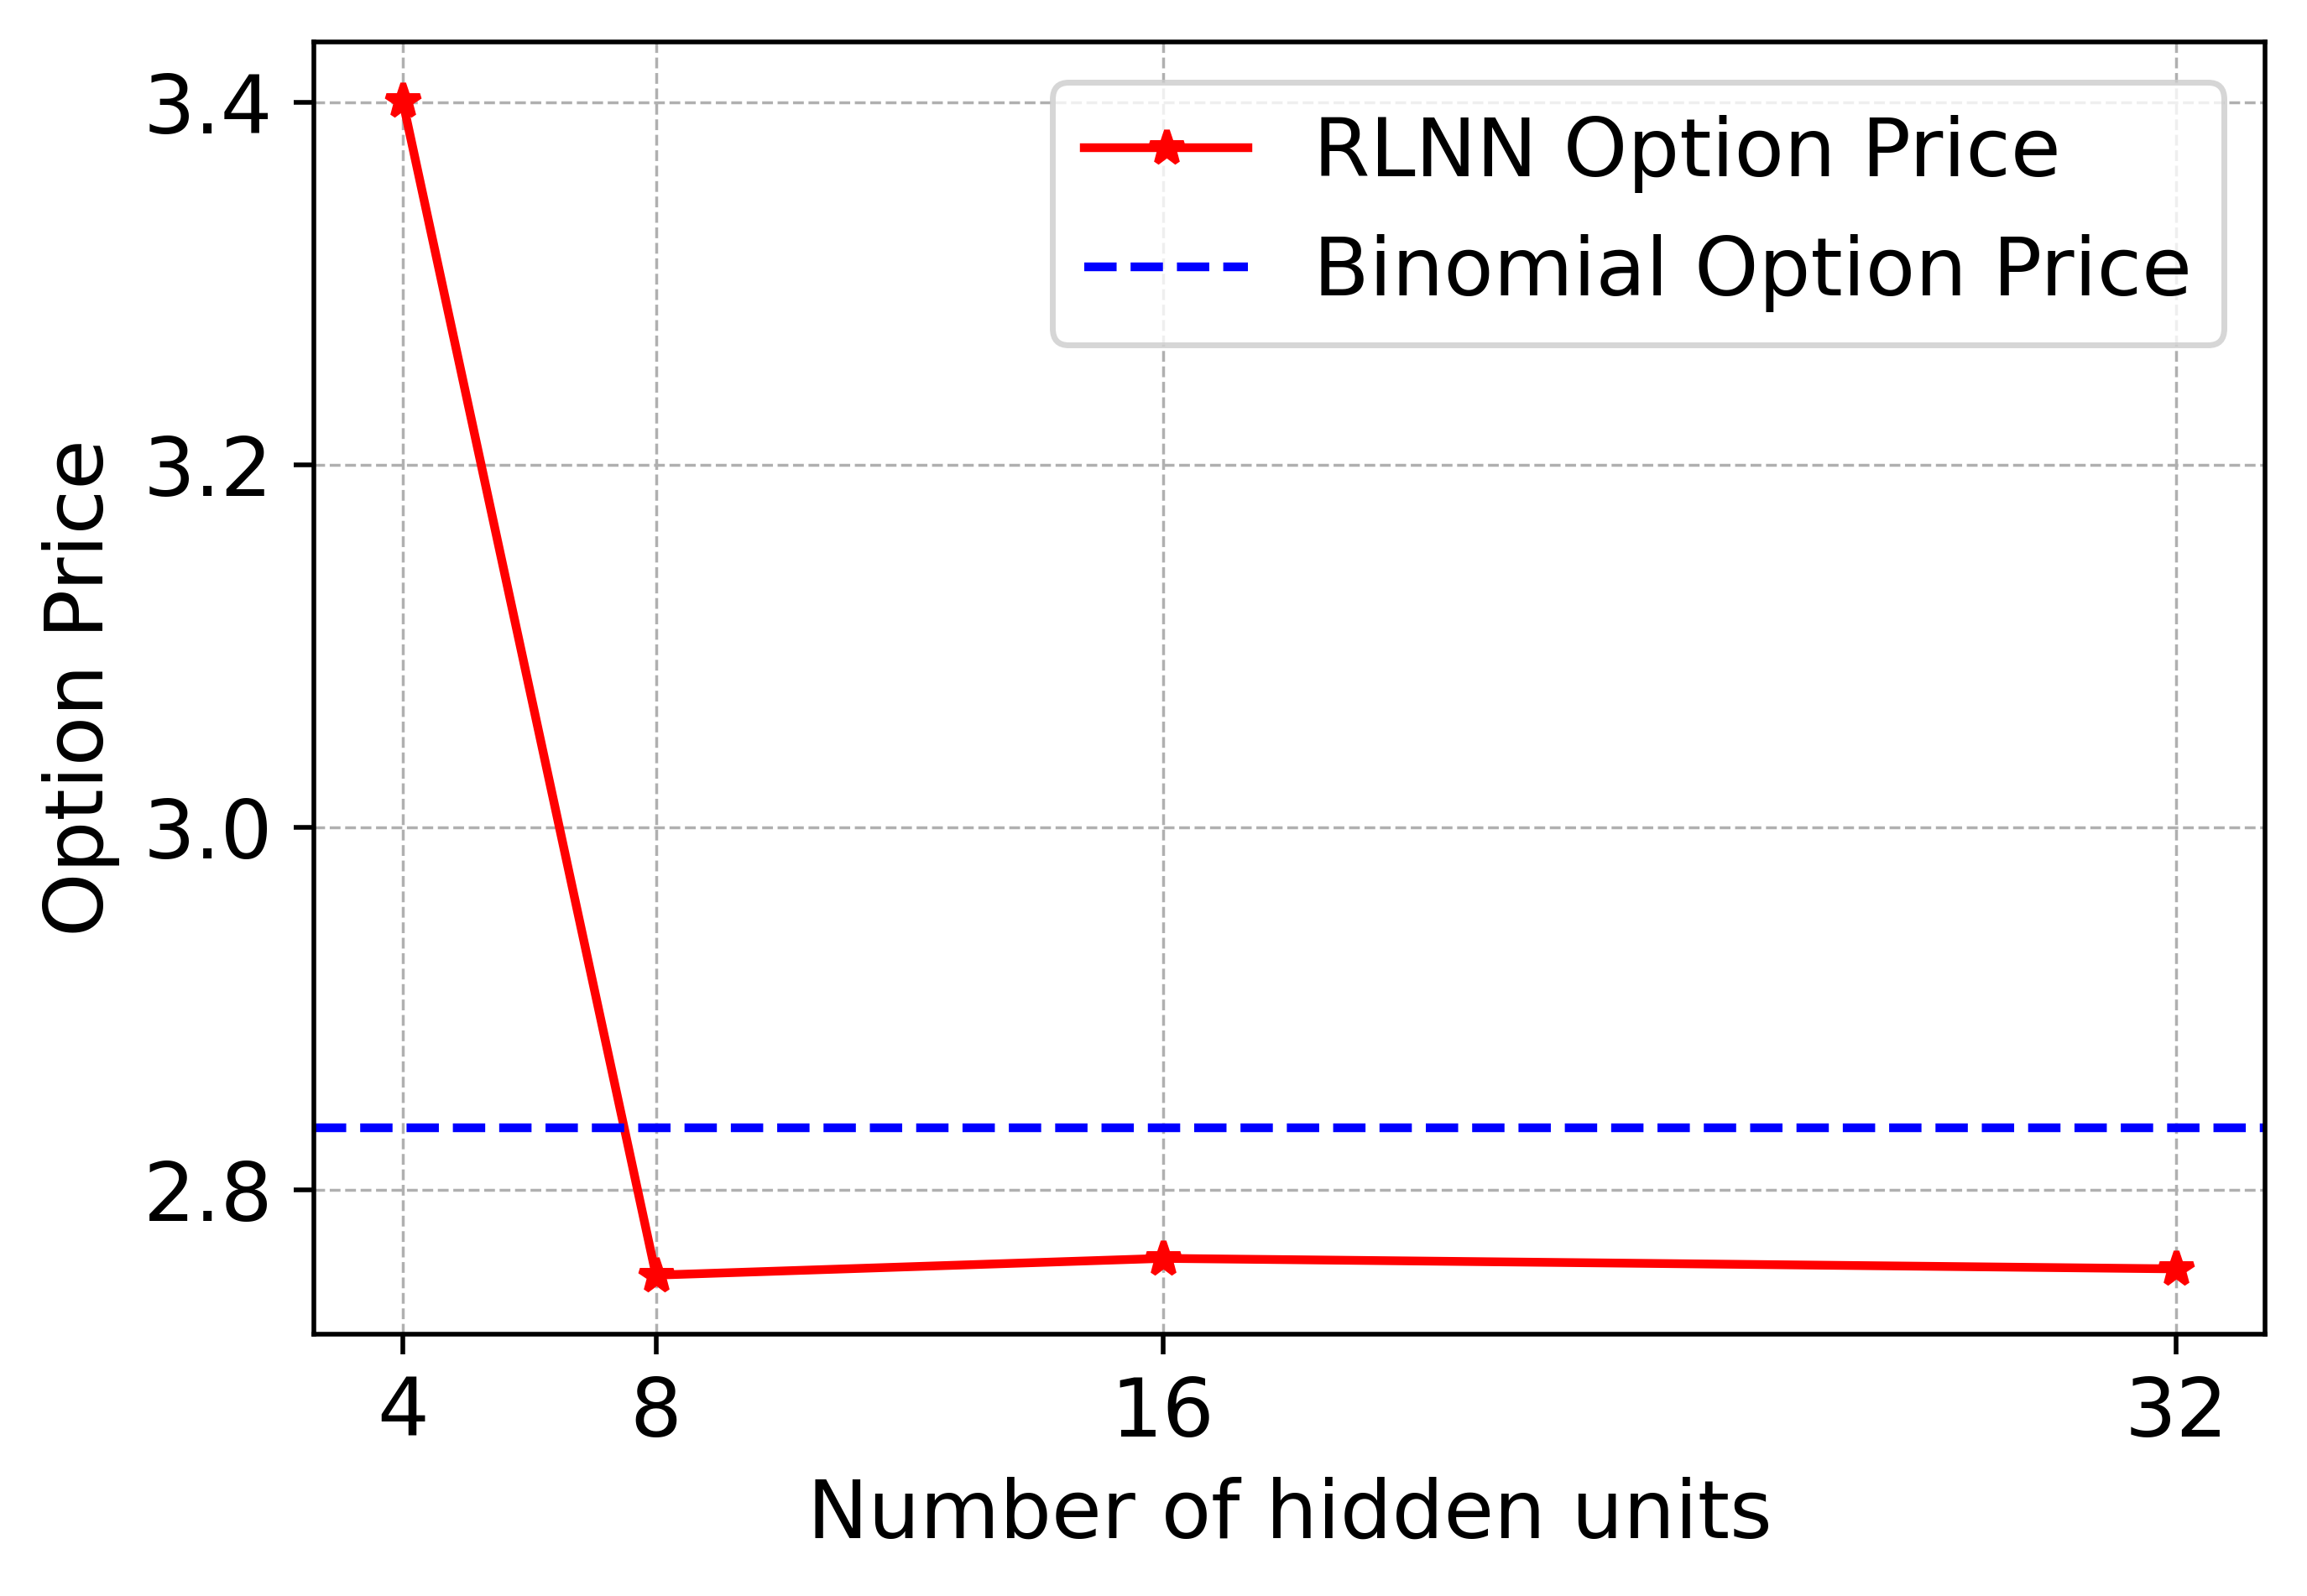

In [35]:
plt.figure(dpi=500, figsize=(6, 4))
plt.plot(hidden_units, option_prices, label='RLNN Option Price', marker='*', color='r')
plt.axhline(y = binomial_price, label='Binomial Option Price', color='b', linestyle='--')  
ticks = hidden_units
plt.xticks(ticks, labels=[str(tick) for tick in ticks])
plt.xlabel('Number of hidden units')
plt.ylabel('Option Price')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.savefig('Option_Price_vs_Hidden_units.png')

### Changes in Sample Size

In [36]:
sample_sizes = np.linspace(1000, 50000, 5, dtype=int)
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 6
hidden_units = 32
option_prices_sim = []
errors_sim = []
times_sim = []

for M in tqdm(sample_sizes):
    option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
    option_prices_sim.append(option_price)
    errors_sim.append(error)
    times_sim.append(time.time())



  0%|          | 0/5 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 20%|██        | 1/5 [01:14<04:56, 74.05s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 40%|████      | 2/5 [04:07<06:38, 132.70s/it]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 60%|██████    | 3/5 [08:12<06:08, 184.06s/it]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


 80%|████████  | 4/5 [13:10<03:49, 229.05s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


100%|██████████| 5/5 [17:55<00:00, 215.11s/it]


In [37]:
errors_sim  = np.array(errors_sim)
option_prices_sim = np.array(option_prices_sim)
times_sim = np.array(times_sim)

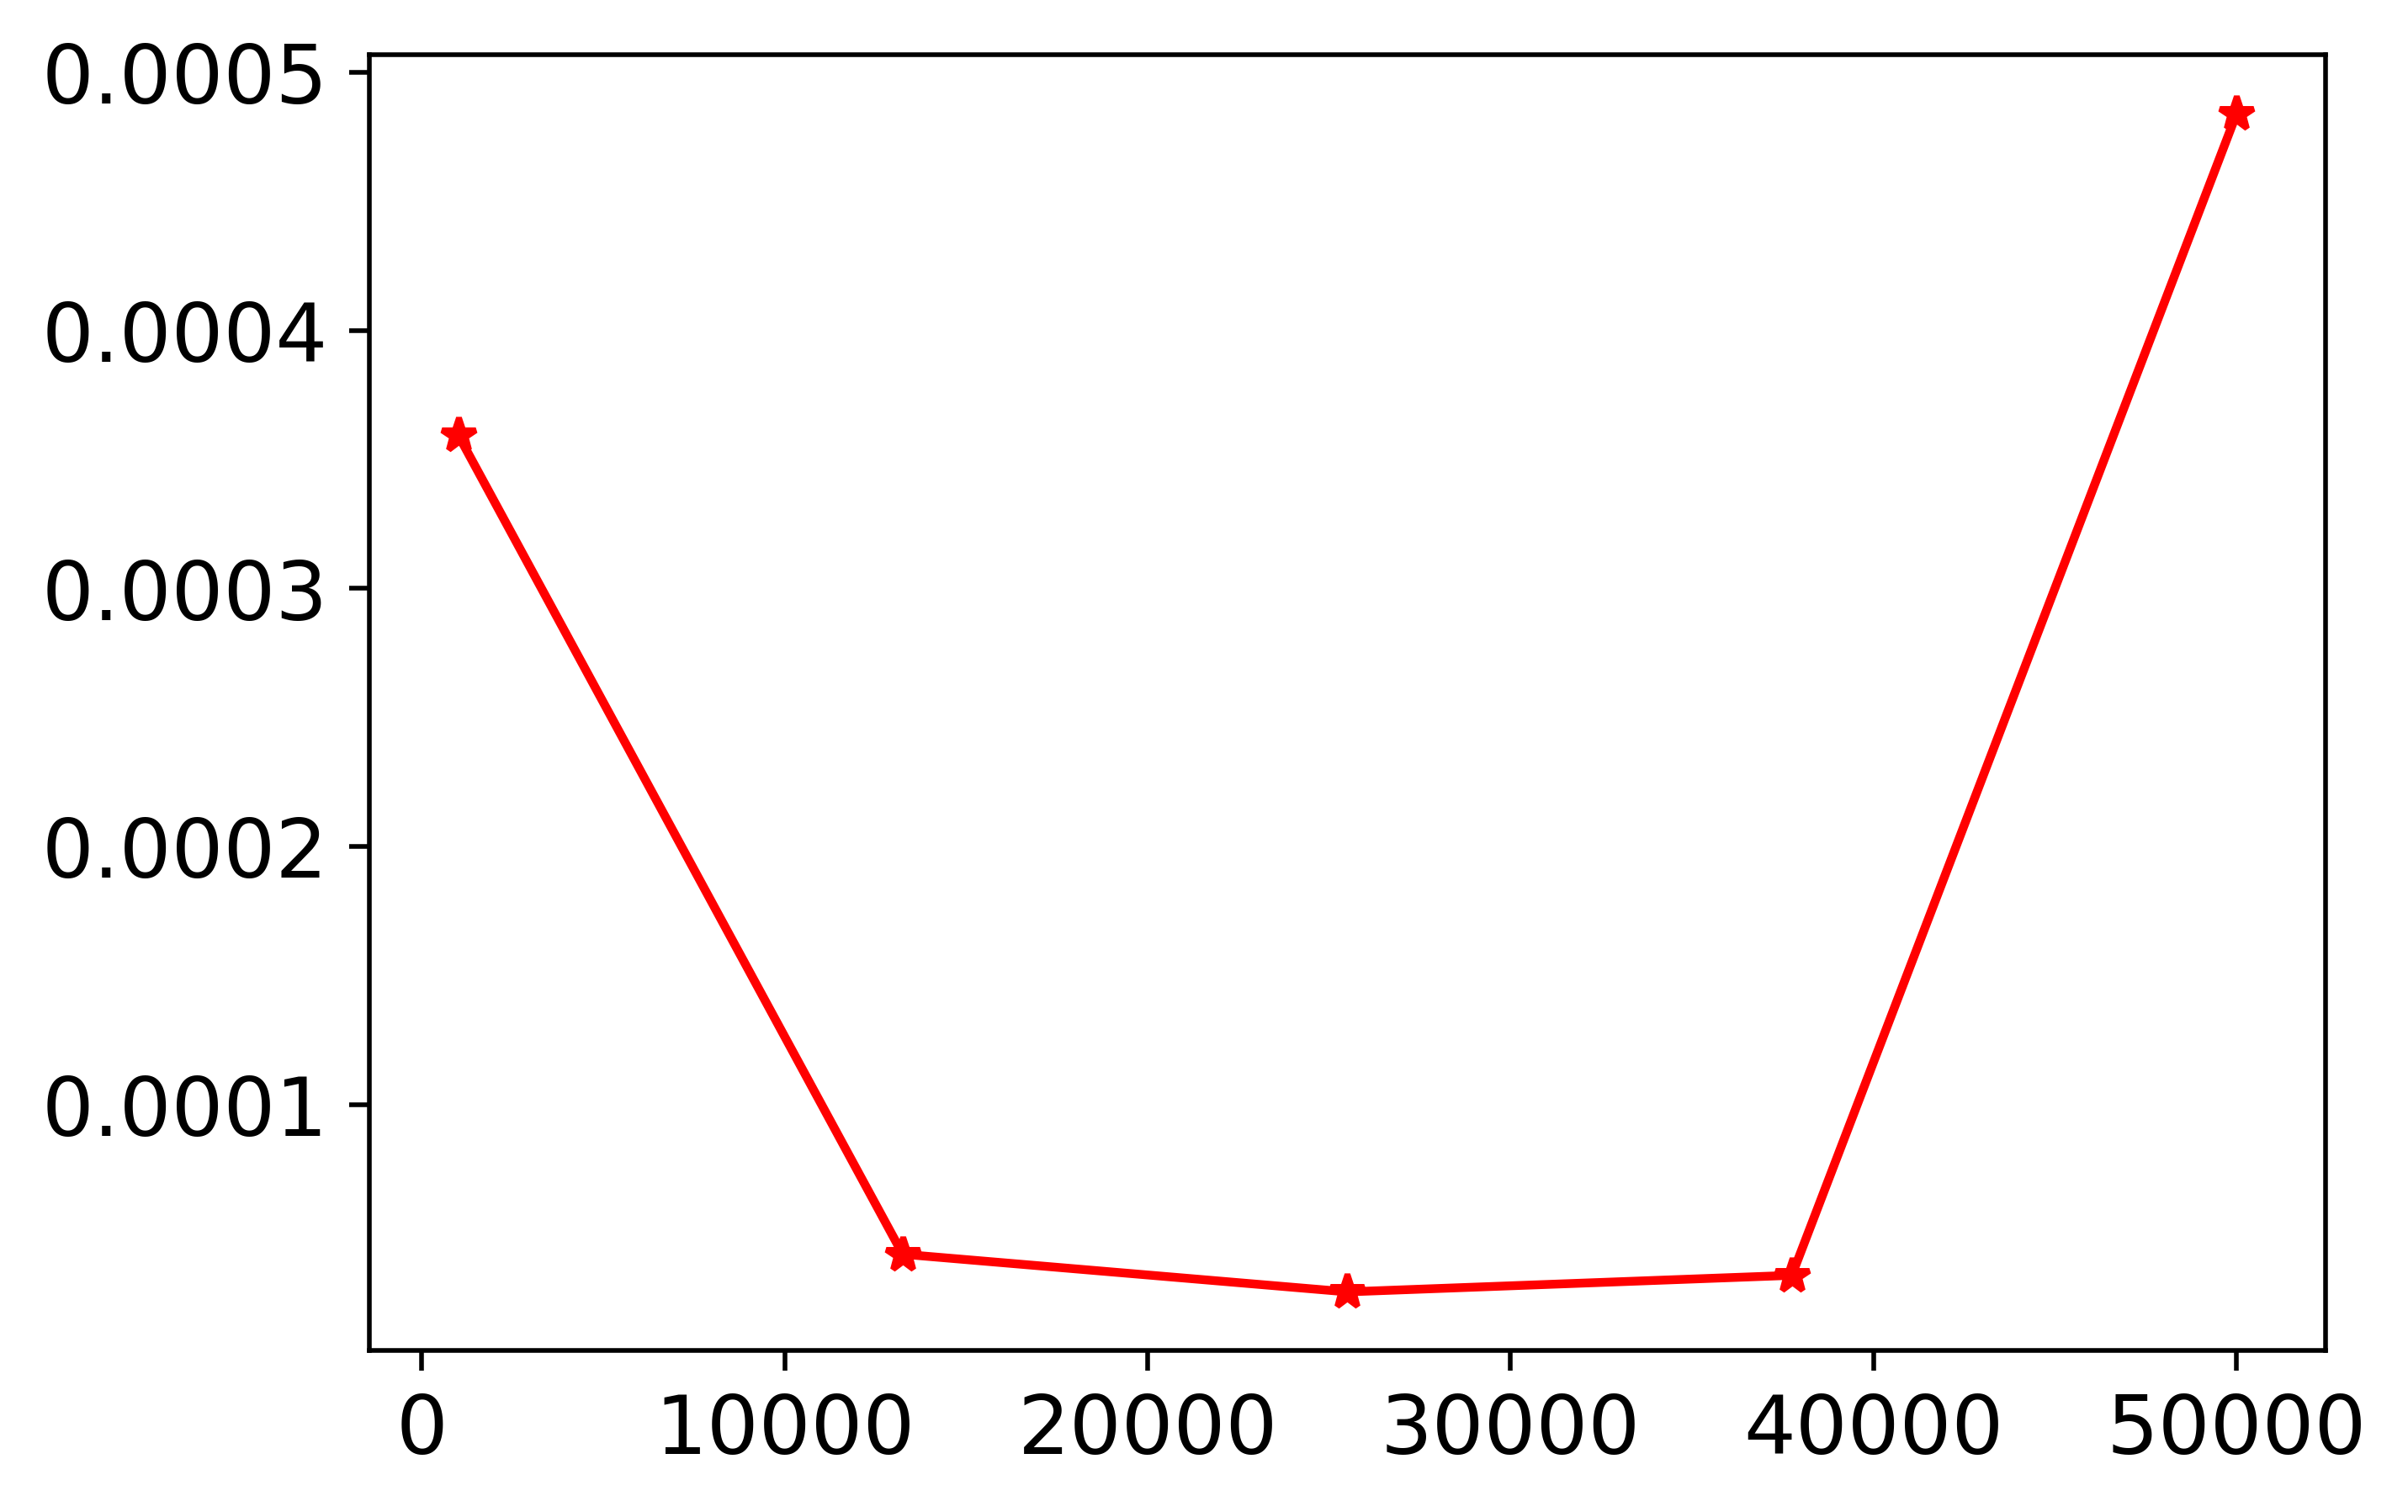

In [38]:
plt.figure(dpi=500, figsize=(6, 4))
plt.plot(sample_sizes, errors_sim[:,-1], label='RLNN fit Error', marker='*', color='r')
plt.show()

In [39]:
sample_sizes = np.linspace(1000, 50000, 5, dtype=int)
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 6
hidden_units = 32
option_prices_sim = []
errors_sim = []
times_sim = []
for M in tqdm(sample_sizes):
    ci_error = []
    time_n = []
    option_prices_n = []
    errors_n = []
    for _ in tqdm(range(5)):
        start_time = time.time()
        option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
        end_time = time.time()
        time_n.append(end_time - start_time)
        option_prices_n.append(option_price)
        errors_n.append(error)
    times_sim.append(np.array(time_n).mean())
    option_prices_sim.append(np.array(option_prices_n).mean())
    errors_sim.append(np.array(errors_n).mean())
    ci = 1.96 * np.std(option_prices_n) / np.sqrt(5)
    ci_error.append(ci)
    

  0%|          | 0/5 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


 20%|██        | 1/5 [05:36<22:24, 336.20s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


 40%|████      | 2/5 [20:04<32:28, 649.38s/it]

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


 60%|██████    | 3/5 [41:34<31:23, 941.75s/it]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


 80%|████████  | 4/5 [1:11:19<21:14, 1274.59s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


100%|██████████| 5/5 [1:44:04<00:00, 1248.98s/it]


In [40]:
option_prices_sim = np.array(option_prices_sim)
times_sim = np.array(times_sim)
errors_sim = np.array(errors_sim)

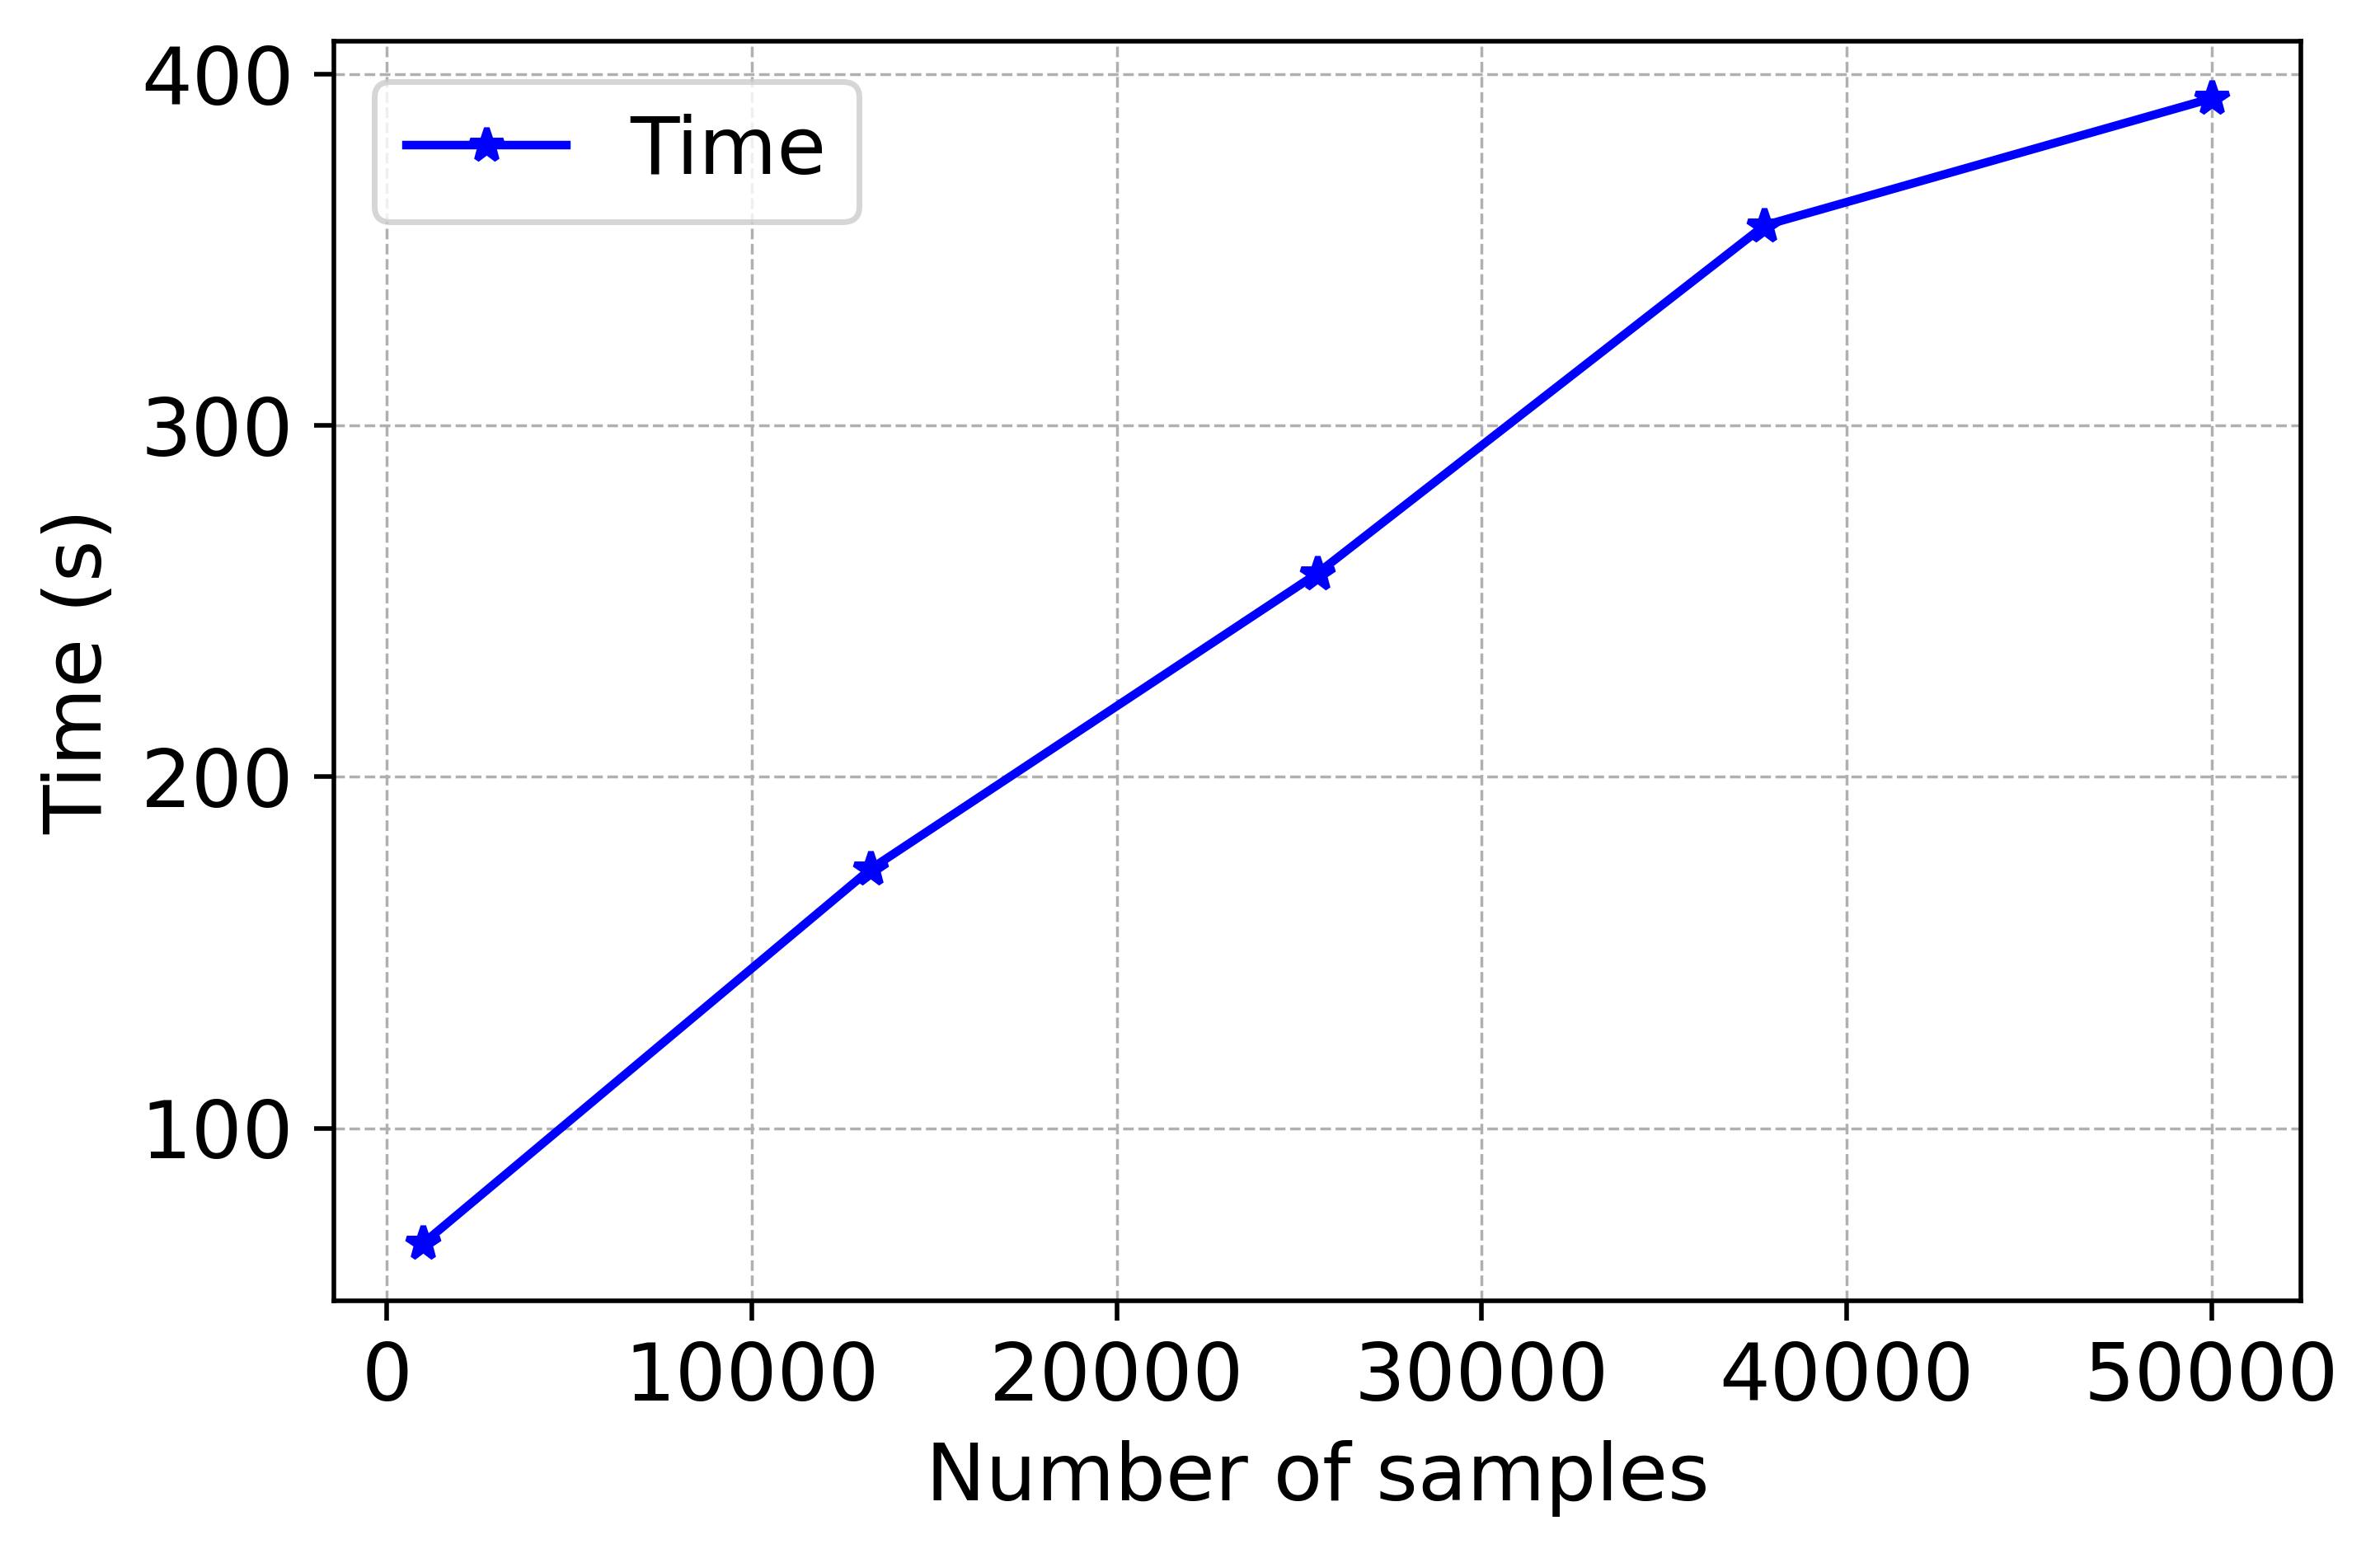

In [41]:
plt.figure(dpi=500, figsize=(6, 4))
plt.plot(sample_sizes, times_sim, label='Time', marker='*', color='b')
plt.xlabel('Number of samples')    
plt.ylabel('Time (s)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('Time_vs_Samples.png')
plt.show()


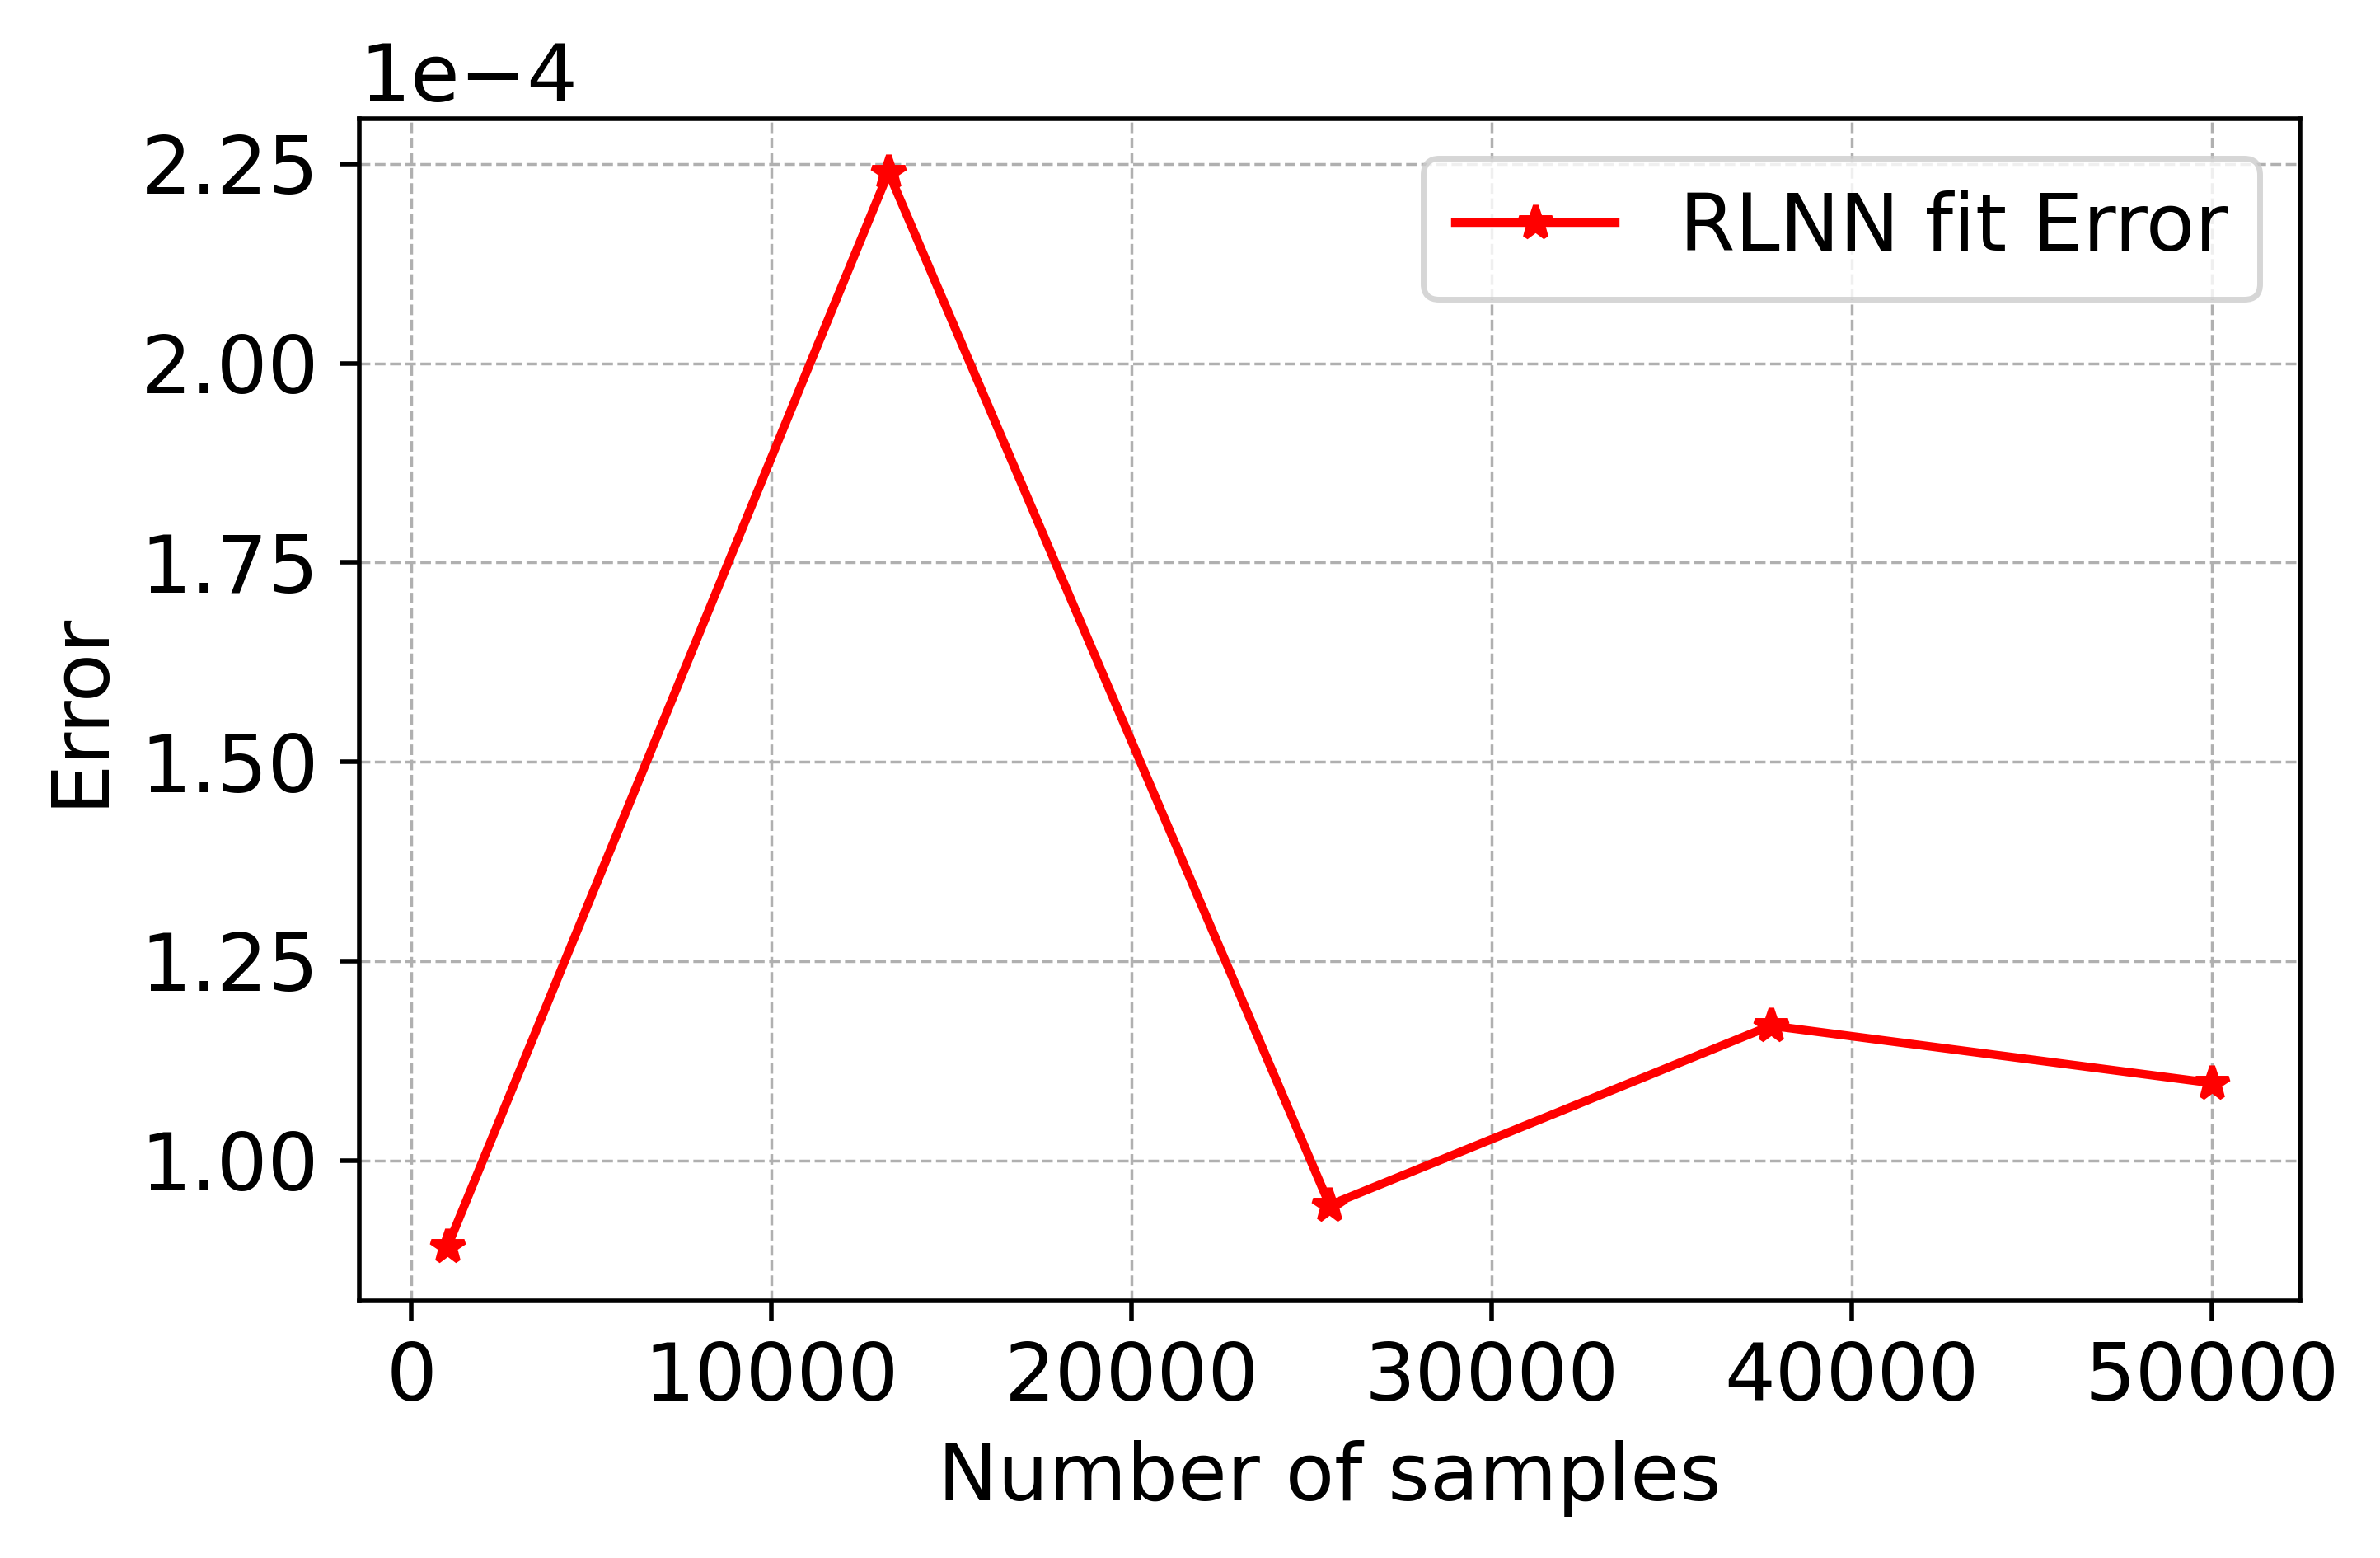

In [42]:
plt.figure(dpi=500, figsize=(6, 4))
plt.plot(sample_sizes, errors_sim, label='RLNN fit Error', marker='*', color='r')
#plt.yscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))  # Force scientific notation
# Adjust layout to fit everything
plt.tight_layout()
plt.savefig('Error_vs_Samples.png')
plt.show()

### Binomial Method

In [43]:
def bermudan_option_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="call"):
    """
    Price a Bermudan option using the Binomial Tree method.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree
    - exercise_dates: List of times (as fractions of T) at which early exercise is allowed
    - option_type: "call" for call option, "put" for put option
    
    Returns:
    - The option price
    """
    
    # Calculate parameters for binomial tree
    dt = T / N  # Time increment
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    
    # Initialize asset prices at maturity
    stock_prices = np.zeros(N + 1)
    stock_prices[0] = S0 * d**N
    for i in range(1, N + 1):
        stock_prices[i] = stock_prices[i - 1] * u / d

    # Initialize option values at maturity
    option_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
    #print(option_values, stock_prices)
    
    # Backward induction for Bermudan option pricing
    for i in range(N - 1, -1, -1):
        stock_prices = stock_prices[:-1] * u  # Step back in time
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])
        
        # Apply early exercise at specified exercise dates
        if i * dt in exercise_dates:
            #print(f"Applying early exercise at time {i * dt}")
            exercise_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
            #print(exercise_values, stock_prices, K)
            option_values = np.maximum(option_values, exercise_values)

    return option_values[0]


In [44]:
no_mon_dates = np.arange(2, 7, 1)
no_mon_dates

array([2, 3, 4, 5, 6])

In [45]:
no_mon_dates

array([2, 3, 4, 5, 6])

### Lower Bounds

In [46]:
def calculate_lower_bound(stock_paths, K, r, sigma, T, no_mon_dates, option_type, trained_weights, nodes):
    """_summary_

    Args:
        S0 (_type_): _description_
        K (_type_): _description_
        r (_type_): _description_
        sigma (_type_): _description_
        T (_type_): _description_
        no_mon_dates (_type_): Number of monitoring dates
        option_type (_type_): _description_

    Returns:
        _type_: _description_
    """
    S0 = stock_paths[0, 0]
    dt = T / no_mon_dates
    M = stock_paths.shape[0]
    
    tau = np.full(stock_paths.shape[0], no_mon_dates-1)
    h_S = payoff_fun(stock_paths[:, no_mon_dates-1], K, option_type)
    
    for m in range(no_mon_dates-1):
        normalizer = S0
        St = stock_paths[:, m]    
        payoff_t = payoff_fun(St, K, option_type)
        current_weights = trained_weights[no_mon_dates - m - 2]
        weights_layer_1 = np.array(current_weights[0]).reshape(-1)
        biases_layer_1 = np.array(current_weights[1])
        weights_layer_2 = np.array(current_weights[2]).reshape(-1)
        biases_layer_2 = np.array(current_weights[3])
        continuation_value = cal_continuation_value(weights_layer_1, biases_layer_1, weights_layer_2, biases_layer_2, nodes, St, r, sigma, dt, M, normalizer)
        exceed = np.logical_and(payoff_t > continuation_value, tau > m)
        tau[exceed] = m
        h_S[exceed] = payoff_t[exceed]
        
        monitoring = np.arange(0, 1.01, 1/no_mon_dates)
        discounted_values = np.zeros(M, dtype=float)
        for j in range(M):
            discounted_values[j] = h_S[j] * np.exp(-r  * monitoring[tau[j]])

        lower_bound = np.mean(discounted_values)

    return lower_bound     

### Upper Bound

In [47]:
def upper_bound(rfr, vol, trained_weights, stock_paths, strike, monitoring, style, nodes):
    
    sample_size = len(stock_paths[:, 0])
    n_mon = len(monitoring)
    differences = np.diff(monitoring)

    b = np.exp(- rfr * np.cumsum(differences))
    b = np.insert(b, 0, 1)
    S0 = stock_paths[0, 0]

    rlnn = create_shallow_NN(1, nodes)

    martingale = np.zeros((sample_size, n_mon))

    for m in range(1, n_mon):
        normalizer = S0
        current_weights = trained_weights[- m]
        rlnn.set_weights(current_weights)
        w1 = np.array(current_weights[0]).reshape(-1)
        b1 = np.array(current_weights[1])
        w2 = np.array(current_weights[2]).reshape(-1)
        b2 = np.array(current_weights[3])
        q = cal_continuation_value(w1, b1, w2, b2, nodes, stock_paths[:, m - 1], rfr, vol, differences[m - 1], sample_size, normalizer)

        q_part = q * b[m - 1]
        g_part = (rlnn.predict(stock_paths[:, m] / normalizer, verbose=0) * b[m]).reshape(-1)

        martingale[:, m] = (g_part - q_part)

    martingale = np.cumsum(martingale, axis=1)

    payoffs = payoff_fun(stock_paths, strike, style)
    upr = np.mean(np.max(payoffs * b - martingale, axis=1))

    return upr

In [48]:
hidden_units = 32

In [49]:
price_, weight_, _ = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


In [50]:
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, 50000)
upper_bound(mu, sigma, weight_, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', hidden_units)

C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


np.float64(2.757064383300645)

In [51]:
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, 10000)
calculate_lower_bound(stock_paths, K, mu, sigma, T, N, 'put', weight_, hidden_units)

C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


np.float64(2.6785654927340095)

In [52]:
price_

np.float64(2.757350012804598)

In [53]:
def bermudan_option_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="call"):
    """
    Price a Bermudan option using the Binomial Tree method.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree
    - exercise_dates: List of times (as fractions of T) at which early exercise is allowed
    - option_type: "call" for call option, "put" for put option
    
    Returns:
    - The option price
    """
    
    # Calculate parameters for binomial tree
    dt = T / N  # Time increment
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    
    # Initialize asset prices at maturity
    stock_prices = np.zeros(N + 1)
    stock_prices[0] = S0 * d**N
    for i in range(1, N + 1):
        stock_prices[i] = stock_prices[i - 1] * u / d

    # Initialize option values at maturity
    option_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
    #print(option_values, stock_prices)
    
    # Backward induction for Bermudan option pricing
    for i in range(N - 1, -1, -1):
        stock_prices = stock_prices[:-1] * u  # Step back in time
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])
        
        # Apply early exercise at specified exercise dates
        if i * dt in exercise_dates:
            #print(f"Applying early exercise at time {i * dt}")
            exercise_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
            #print(exercise_values, stock_prices, K)
            option_values = np.maximum(option_values, exercise_values)

    return option_values[0]


In [54]:
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 4
M = 10000
n_steps = 4 * 50
exercise_dates = np.arange(0, 1.0001, 1/4)
b_prices = []
for n_steps in range(4, 4 * 50, 4):
    b_price = bermudan_option_binomial(S0, K, T, mu, sigma,  n_steps, exercise_dates, 'put')
    b_prices.append(b_price)



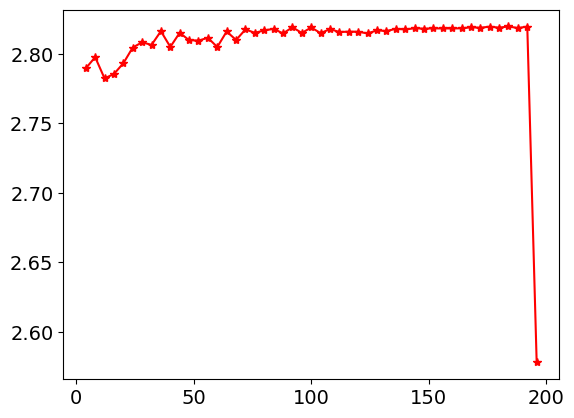

In [55]:
plt.plot(np.arange(4, 4 * 50, 4), b_prices, label='Binomial Option Price', marker='*', color='r')

In [56]:
black_scholes(S0, K, mu, sigma, T, 'put')

np.float64(2.5830012555254314)

In [57]:
M = 10000
N = 4
hidden_units = 4
T = 1
RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, 0.001)[0]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


np.float64(2.7454305889184574)

In [58]:
hidden_units

4

In [59]:
def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    ##Pre Training the neural network
    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    model.fit(stock_paths[:, N].reshape(-1, 1), payoff_T.reshape(-1, 1), epochs=1000, batch_size=int(0.1 * sample_size), verbose=0)
    ## Pre Training completed   
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = create_shallow_NN(1, no_hidden_units)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    ## Train the model  
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)
    
    # Test the model
    y_hat_val = model.predict(X_test)
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    #plt.scatter(X_train, y_train, label='Actual')
    # Sort X_train and y_hat for a smoother line plot
    #sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
    #X_train_sorted = X_train[sorted_indices]
    #y_hat_sorted = y_hat_val[sorted_indices]
    #plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
    #plt.show()
    
    ## Get the weights of the model
    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    ## Calculate the option price at the previous monitoring dates
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose =0)
        
        y_hat = model.predict(X_test)
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append(model.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
        
    return option_price[0, 0], weights, errors, stock_paths

    

In [60]:
no_hidden_units = [2, 4, 6, 8, 10, 16, 32]
option_prices_nodes = []
lower_Nodes = []
upper_Nodes = []
times_upper = []
times_lower = []
times_option = []
N_L = 20000
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 4
M = 1500

for hidden_units in tqdm(no_hidden_units):
    start_time1 = time.time()
    option_price, trained_weights, error, stock_paths = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
    ends_time1 = time.time()
    option_prices_nodes.append(option_price)
    times_option.append(ends_time1 - start_time1)
    
    stock_paths = stock_price_simulator(S0, mu, sigma, T, N, N_L)
    start_time2 = time.time()
    lower_bound = calculate_lower_bound(stock_paths, K, mu, sigma, T, N, 'put', trained_weights, hidden_units)
    end_time2 = time.time()
    lower_Nodes.append(lower_bound)
    times_lower.append(end_time2 - start_time2)
    
    start_time3 = time.time()
    upper_bound1 = upper_bound(mu, sigma, trained_weights, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', hidden_units)
    end_time3 = time.time()
    upper_Nodes.append(upper_bound1)
    times_upper.append(end_time3 - start_time3)
    

  0%|          | 0/7 [00:00<?, ?it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 1/7 [01:17<07:46, 77.76s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


 29%|██▊       | 2/7 [02:30<06:15, 75.07s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


 43%|████▎     | 3/7 [03:32<04:35, 68.99s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 4/7 [05:18<04:10, 83.37s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


 71%|███████▏  | 5/7 [07:05<03:04, 92.08s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


 86%|████████▌ | 6/7 [09:32<01:50, 110.56s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 7/7 [13:38<00:00, 116.95s/it]


In [61]:
option_prices_nodes, lower_Nodes, upper_Nodes

([np.float64(2.7707862422591525),
  np.float64(5.278560272518576),
  np.float64(5.10535049980138),
  np.float64(2.737715374539817),
  np.float64(2.7305103700791276),
  np.float64(2.7396220867884),
  np.float64(2.7239225939781933)],
 [np.float64(2.5448688514021334),
  np.float64(2.534407590028551),
  np.float64(2.5139985238902396),
  np.float64(2.564182910589845),
  np.float64(2.548946539125301),
  np.float64(2.585983364776677),
  np.float64(2.589526914868559)],
 [np.float64(2.780284772688155),
  np.float64(3.993237922861134),
  np.float64(3.9665919822261575),
  np.float64(2.7298814559912987),
  np.float64(2.728811517617365),
  np.float64(2.7293382944278664),
  np.float64(2.7257882127410213)])

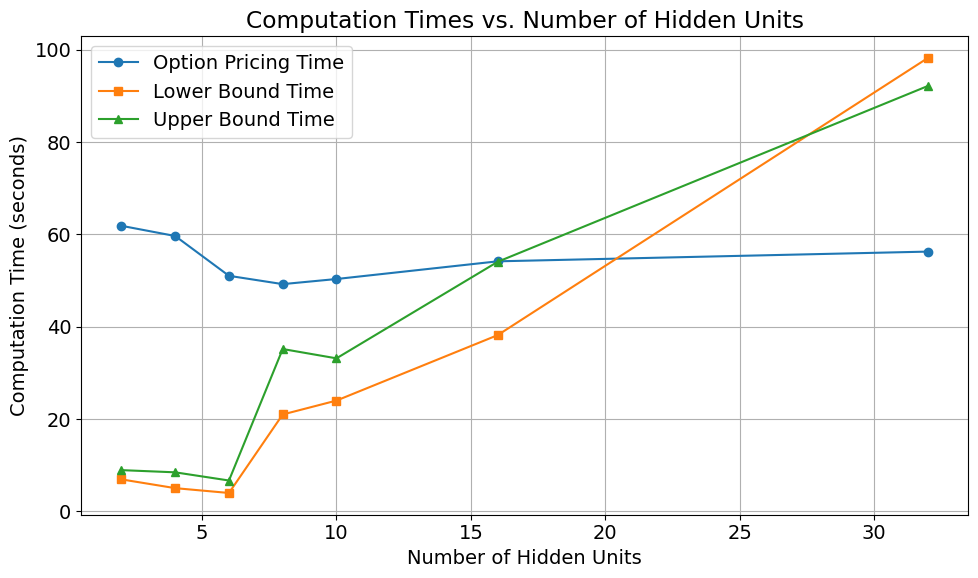

In [62]:
import matplotlib.pyplot as plt

# Plot the computation times
plt.figure(figsize=(10, 6))

# Plot each time array
plt.plot(no_hidden_units, times_option, marker='o', label="Option Pricing Time")
plt.plot(no_hidden_units, times_lower, marker='s', label="Lower Bound Time")
plt.plot(no_hidden_units, times_upper, marker='^', label="Upper Bound Time")

# Add labels, legend, and grid
plt.xlabel("Number of Hidden Units")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Times vs. Number of Hidden Units")
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
import matplotlib.pyplot as plt

def plot_results(results, results_RLLN=None):
    """
    Plot results for binomial method and optional RLNN results.

    Parameters:
    - results: List of dictionaries containing binomial results.
    - results_RLLN: (Optional) List of dictionaries containing RLNN results.
    """
    for result in results:
        volatility = result['volatility']
        # no_steps = result['no_steps']
        # option_prices = result['option_prices_steps']
        # times = result['times_steps']

        plt.figure(figsize=(12, 6))
        
        # Plot option prices vs number of steps
        plt.subplot(1, 2, 1)
        plt.plot(no_steps, option_prices, label=f'Binomial (Vol={volatility})', marker='o')
        if results_RLLN:
            for rlnn_result in results_RLLN:
                if rlnn_result['volatility'] == volatility:
                    plt.plot(no_steps, rlnn_result['option_prices_steps'], label=f'RLNN (Vol={volatility})', linestyle='--', marker='x')
        plt.xlabel('Number of Steps')
        plt.ylabel('Option Price')
        plt.title(f'Option Prices for Volatility {volatility}')
        plt.legend()
        plt.grid()

        # Plot computation time vs number of steps
        plt.subplot(1, 2, 2)
        plt.plot(no_steps, times, label=f'Binomial Time (Vol={volatility})', marker='o')
        if results_RLLN:
            for rlnn_result in results_RLLN:
                if rlnn_result['volatility'] == volatility:
                    plt.plot(no_steps, rlnn_result['times_steps'], label=f'RLNN Time (Vol={volatility})', linestyle='--', marker='x')
        plt.xlabel('Number of Steps')
        plt.ylabel('Computation Time (s)')
        plt.title(f'Computation Time for Volatility {volatility}')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()


In [64]:
import json

volatilities = [0.05, 0.1, 0.2]  # Example volatilities to test
results_RLLN = []

for sigma in volatilities:
    print(f"Testing for volatility: {sigma}")
    no_hidden_units = [2, 4, 6, 8, 10, 16, 32]
    option_prices_nodes = []
    lower_Nodes = []
    upper_Nodes = []
    times_upper = []
    times_lower = []
    times_option = []
    N_L = 20000
    S0 = 50
    K = 50
    mu = 0.06
    T = 1
    N = 4
    M = 1500

    for hidden_units in tqdm(no_hidden_units):
        start_time1 = time.time()
        option_price, trained_weights, error, stock_paths = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
        ends_time1 = time.time()
        option_prices_nodes.append(option_price)
        times_option.append(ends_time1 - start_time1)
        
        stock_paths = stock_price_simulator(S0, mu, sigma, T, N, N_L)
        start_time2 = time.time()
        lower_bound = calculate_lower_bound(stock_paths, K, mu, sigma, T, N, 'put', trained_weights, hidden_units)
        end_time2 = time.time()
        lower_Nodes.append(lower_bound)
        times_lower.append(end_time2 - start_time2)
        
        start_time3 = time.time()
        upper_bound1 = upper_bound(mu, sigma, trained_weights, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', hidden_units)
        end_time3 = time.time()
        upper_Nodes.append(upper_bound1)
        times_upper.append(end_time3 - start_time3)

    # Store results for this volatility
    results_RLLN.append({
        "volatility": sigma,
        "option_prices_nodes": option_prices_nodes,
        "lower_Nodes": lower_Nodes,
        "upper_Nodes": upper_Nodes,
        "times_option": times_option,
        "times_lower": times_lower,
        "times_upper": times_upper
    })

# Save results to a JSON file
output_file = "results_RLLN.json"
with open(output_file, "w") as f:
    json.dump(results_RLLN, f, indent=4)

print(f"All simulations completed. Results saved to {output_file}.")


Testing for volatility: 0.05


  0%|          | 0/7 [00:00<?, ?it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


 14%|█▍        | 1/7 [01:21<08:07, 81.33s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


 29%|██▊       | 2/7 [02:46<06:58, 83.79s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


 43%|████▎     | 3/7 [04:17<05:47, 86.82s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


 57%|█████▋    | 4/7 [06:27<05:11, 103.78s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


 71%|███████▏  | 5/7 [08:36<03:46, 113.18s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


 86%|████████▌ | 6/7 [10:42<01:57, 117.35s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


100%|██████████| 7/7 [13:52<00:00, 118.88s/it]


Testing for volatility: 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 1/7 [01:06<06:38, 66.49s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 29%|██▊       | 2/7 [02:50<07:23, 88.60s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 43%|████▎     | 3/7 [04:54<06:58, 104.55s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


 57%|█████▋    | 4/7 [07:05<05:45, 115.13s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


 71%|███████▏  | 5/7 [08:47<03:41, 110.56s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 86%|████████▌ | 6/7 [11:20<02:04, 124.85s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


100%|██████████| 7/7 [15:10<00:00, 130.07s/it]


Testing for volatility: 0.2


  0%|          | 0/7 [00:00<?, ?it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


 14%|█▍        | 1/7 [01:03<06:21, 63.60s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


 29%|██▊       | 2/7 [02:07<05:19, 63.80s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


 43%|████▎     | 3/7 [03:32<04:52, 73.25s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 4/7 [04:41<03:35, 71.75s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 71%|███████▏  | 5/7 [06:19<02:42, 81.12s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


 86%|████████▌ | 6/7 [08:11<01:31, 91.69s/it]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


100%|██████████| 7/7 [11:18<00:00, 96.89s/it] 

All simulations completed. Results saved to results_RLLN.json.


In [65]:
results_RLLN

[{'volatility': 0.05,
  'option_prices_nodes': [np.float64(0.5450272285693583),
   np.float64(0.5446792701623087),
   np.float64(0.2903266377386272),
   np.float64(0.292389734471917),
   np.float64(0.28856048475281915),
   np.float64(0.2812503926023248),
   np.float64(0.2856430662994709)],
  'lower_Nodes': [np.float64(0.27771328920408167),
   np.float64(0.274838405426473),
   np.float64(0.2788699301517227),
   np.float64(0.2748438890984244),
   np.float64(0.28286954012659754),
   np.float64(0.2778563534391232),
   np.float64(0.2745532973731577)],
  'upper_Nodes': [np.float64(0.39265573496233),
   np.float64(0.3847054890679345),
   np.float64(0.28624503726070205),
   np.float64(0.2872852166185764),
   np.float64(0.28478985555422803),
   np.float64(0.2844383130221004),
   np.float64(0.2842070279681347)],
  'times_option': [56.086299657821655,
   53.36359405517578,
   72.52835536003113,
   69.85434913635254,
   70.90309071540833,
   59.69221591949463,
   72.31074070930481],
  'times_lower

In [66]:
# plt.plot(no_hidden_units, option_prices_nodes, label='RLNN Put Option Price', marker='*', color='r')
# plt.plot(no_hidden_units, lower_Nodes, label='Lower Bound', marker='*', color='b')
# plt.plot(no_hidden_units, upper_Nodes, label='Upper Bound', marker='*', color='g')
# plt.axhline(y = binomial_price, label='Binomial Put Option Price', color='black', linestyle='--')
# plt.legend()

In [67]:
# Test volatilities and number of binomial tree steps
volatilities = [0.05, 0.1, 0.2]  # Example volatilities
results = []

# Parameters for the Bermudan option
S0 = 50  # Initial stock price
K = 50   # Strike price
T = 1    # Time to maturity (1 year)
r = 0.06  # Risk-free rate
exercise_dates = [0.25, 0.5, 0.75]  # Bermudan exercise dates (fractions of T)
option_type = "put"  # Option type
no_steps = [10, 20, 30, 50, 100, 200]  # Different step counts to evaluate

for sigma in volatilities:
    print(f"Testing for volatility: {sigma}")
    option_prices_steps = []
    times_steps = []

    for steps in tqdm(no_steps):
        # Time the computation
        start_time = time.time()
        option_price = bermudan_option_binomial(S0, K, T, r, sigma, steps, exercise_dates, option_type)
        end_time = time.time()

        # Store results
        option_prices_steps.append(option_price)
        times_steps.append(end_time - start_time)

    # Append results for this volatility
    results.append({
        "volatility": sigma,
        "option_prices_steps": option_prices_steps,
        "times_steps": times_steps,
        "no_steps": no_steps
    })

print("All simulations completed.")


Testing for volatility: 0.05


100%|██████████| 6/6 [00:00<00:00, 861.49it/s]


Testing for volatility: 0.1


100%|██████████| 6/6 [00:00<00:00, 2908.00it/s]


Testing for volatility: 0.2


100%|██████████| 6/6 [00:00<00:00, 3121.15it/s]

All simulations completed.


In [68]:
results_RLLN

[{'volatility': 0.05,
  'option_prices_nodes': [np.float64(0.5450272285693583),
   np.float64(0.5446792701623087),
   np.float64(0.2903266377386272),
   np.float64(0.292389734471917),
   np.float64(0.28856048475281915),
   np.float64(0.2812503926023248),
   np.float64(0.2856430662994709)],
  'lower_Nodes': [np.float64(0.27771328920408167),
   np.float64(0.274838405426473),
   np.float64(0.2788699301517227),
   np.float64(0.2748438890984244),
   np.float64(0.28286954012659754),
   np.float64(0.2778563534391232),
   np.float64(0.2745532973731577)],
  'upper_Nodes': [np.float64(0.39265573496233),
   np.float64(0.3847054890679345),
   np.float64(0.28624503726070205),
   np.float64(0.2872852166185764),
   np.float64(0.28478985555422803),
   np.float64(0.2844383130221004),
   np.float64(0.2842070279681347)],
  'times_option': [56.086299657821655,
   53.36359405517578,
   72.52835536003113,
   69.85434913635254,
   70.90309071540833,
   59.69221591949463,
   72.31074070930481],
  'times_lower

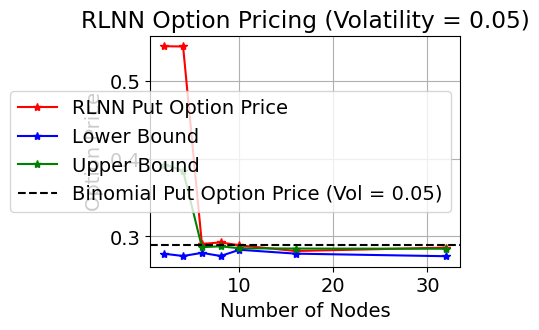

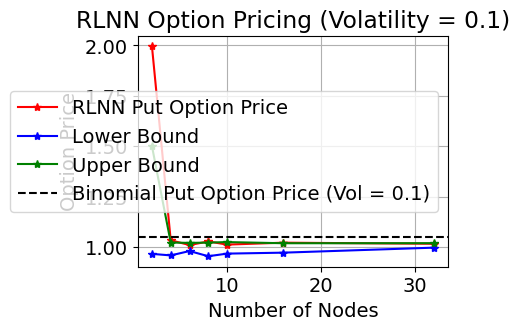

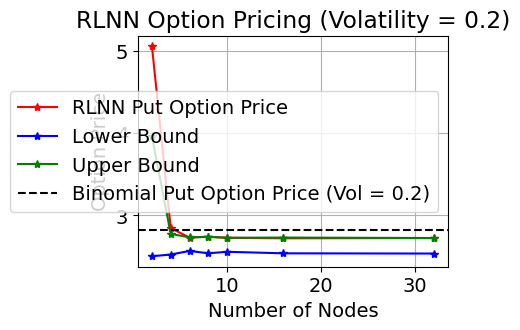

In [69]:
def plot_volatility_results_with_nodes(results, nodes, S0, K, T, r, N, exercise_dates, option_type="put"):
    """
    Create separate full plots for RLNN results for each volatility with nodes as x-axis 
    and dynamically calculate binomial prices.

    Parameters:
    - results: List of dictionaries containing RLNN results for each volatility.
    - nodes: List of node counts used in the experiment.
    - S0: Initial stock price.
    - K: Strike price.
    - T: Time to maturity.
    - r: Risk-free interest rate.
    - N: Number of steps for the binomial method.
    - exercise_dates: List of Bermudan option exercise dates.
    - option_type: Type of the option ("call" or "put").
    """
    for result in results:
        volatility = result['volatility']
        option_prices_nodes = result['option_prices_nodes']
        lower_Nodes = result['lower_Nodes']
        upper_Nodes = result['upper_Nodes']

        # Calculate the binomial price for the given volatility
        binomial_price = bermudan_option_binomial(S0, K, T, r, volatility, N, exercise_dates, option_type)

        # Create the plot
        plt.figure(figsize=(4, 3))
        plt.plot(nodes, option_prices_nodes, label='RLNN Put Option Price', marker='*', color='r')
        plt.plot(nodes, lower_Nodes, label='Lower Bound', marker='*', color='b')
        plt.plot(nodes, upper_Nodes, label='Upper Bound', marker='*', color='g')
        plt.axhline(y=binomial_price, label=f'Binomial Put Option Price (Vol = {volatility})', color='black', linestyle='--')
        plt.xlabel('Number of Nodes')
        plt.ylabel('Option Price')
        plt.title(f"RLNN Option Pricing (Volatility = {volatility})")
        plt.legend()
        plt.grid()
        plt.show()


# Example usage
S0 = 50  # Initial stock price
K = 50   # Strike price
T = 1    # Time to maturity
r = 0.06  # Risk-free interest rate
N = 100  # Number of steps in the binomial tree
exercise_dates = [0.25, 0.5, 0.75, 1]  # Bermudan option exercise dates
nodes = [2, 4, 6, 8, 10, 16, 32]  # Node counts used in the experiment

plot_volatility_results_with_nodes(results_RLLN, nodes, S0, K, T, r, N, exercise_dates, option_type="put")


In [70]:
def generate_figure_caption(S0, K, mu, sigma, T, N, M, N_L):
    """
    Prints the parameters in a formatted way for quick reference.
    """
    print(f"Parameters:")
    print(f"S0 (Initial Stock Price): {S0}")
    print(f"K (Strike Price): {K}")
    print(f"μ (Drift Rate): {mu}")
    print(f"σ (Volatility): {sigma}")
    print(f"T (Time to Maturity): {T}")
    print(f"N (Number of Steps): {N}")
    print(f"M (Number of Simulations): {M}")
    print(f"N_L (Number of Iterations/Samples): {N_L}")


In [71]:
generate_figure_caption(S0=50, K=50, mu=0.06, sigma=0.2, T=1, N=4, M=1500, N_L=20000)


Parameters:
S0 (Initial Stock Price): 50
K (Strike Price): 50
μ (Drift Rate): 0.06
σ (Volatility): 0.2
T (Time to Maturity): 1
N (Number of Steps): 4
M (Number of Simulations): 1500
N_L (Number of Iterations/Samples): 20000


In [72]:
def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    ##Pre Training the neural network
    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    model.fit(stock_paths[:, N].reshape(-1, 1), payoff_T.reshape(-1, 1), epochs=1000, batch_size=int(0.1 * sample_size), verbose=0)
    ## Pre Training completed   
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = create_shallow_NN(1, no_hidden_units)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    ## Train the model  
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)
    
    # Test the model
    y_hat_val = model.predict(X_test)
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    #plt.scatter(X_train, y_train, label='Actual')
    # Sort X_train and y_hat for a smoother line plot
    #sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
    #X_train_sorted = X_train[sorted_indices]
    #y_hat_sorted = y_hat_val[sorted_indices]
    #plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
    #plt.show()
    
    ## Get the weights of the model
    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    ## Calculate the option price at the previous monitoring dates
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose =0)
        
        y_hat = model.predict(X_test)
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append(model.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
        
    return option_price[0, 0], weights, errors, stock_paths

    

In [73]:
# Parameters
volatility = 0.1  # Fixed single volatility
learning_rates = [0.01, 0.05, 0.1]  # Learning rates to test
hidden_units_list = [2, 4, 6, 8, 10, 16, 32]  # Different numbers of nodes to test
results_RLLN = []

# Progress bar for nodes
for no_hidden_units in tqdm(hidden_units_list, desc="Hidden Units", unit="nodes"):
    current_results = []
    for ler_rate in tqdm(learning_rates, desc=f"Learning Rates (Nodes {no_hidden_units})", unit="rate", leave=False):
        try:
            option_prices_nodes = []
            lower_Nodes = []
            upper_Nodes = []
            times_upper = []
            times_lower = []
            times_option = []

            # Parameters for simulation
            N_L = 20000
            S0 = 50
            K = 50
            mu = 0.06
            T = 1
            N = 4
            M = 1500

            # RLNN simulation
            start_time1 = time.time()
            option_price, trained_weights, error, paths = RLNN_Algo(S0, K, mu, volatility, M, N, T, 'put', no_hidden_units, ler_rate)
            end_time1 = time.time()
            option_prices_nodes.append(option_price)
            times_option.append(end_time1 - start_time1)

            # Stock path simulation
            stock_paths = stock_price_simulator(S0, mu, volatility, T, N, N_L)

            # Lower bound calculation
            start_time2 = time.time()
            lower_bound = calculate_lower_bound(stock_paths, K, mu, volatility, T, N, 'put', trained_weights, no_hidden_units)
            end_time2 = time.time()
            lower_Nodes.append(lower_bound)
            times_lower.append(end_time2 - start_time2)

            # Upper bound calculation
            start_time3 = time.time()
            upper_bound1 = upper_bound(mu, volatility, trained_weights, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', no_hidden_units)
            end_time3 = time.time()
            upper_Nodes.append(upper_bound1)
            times_upper.append(end_time3 - start_time3)

            # Collect results for this learning rate
            current_results.append({
                "learning_rate": ler_rate,
                "option_prices_nodes": option_prices_nodes,
                "lower_Nodes": lower_Nodes,
                "upper_Nodes": upper_Nodes,
                "times_option": times_option,
                "times_lower": times_lower,
                "times_upper": times_upper
            })
        except Exception as e:
            print(f"Error with {no_hidden_units} nodes and learning rate {ler_rate}: {e}")
            continue

    # Append results for this number of nodes
    results_RLLN.append({
        "hidden_units": no_hidden_units,
        "results": current_results
    })

# Save results to JSON
output_file = "results_RLLN_different_nodes.json"
with open(output_file, "w") as f:
    json.dump(results_RLLN, f, indent=4)

print(f"Simulation completed. Results saved to {output_file}.")


Hidden Units:   0%|          | 0/7 [00:00<?, ?nodes/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


Hidden Units:  14%|█▍        | 1/7 [03:16<19:37, 196.30s/nodes]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Hidden Units:  29%|██▊       | 2/7 [06:35<16:30, 198.09s/nodes]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Hidden Units:  43%|████▎     | 3/7 [10:17<13:55, 209.00s/nodes]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Hidden Units:  57%|█████▋    | 4/7 [15:29<12:28, 249.55s/nodes]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Hidden Units:  71%|███████▏  | 5/7 [20:15<08:45, 262.82s/nodes]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Hidden Units:  86%|████████▌ | 6/7 [27:04<05:12, 312.36s/nodes]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


Hidden Units: 100%|██████████| 7/7 [34:48<00:00, 298.39s/nodes]

Simulation completed. Results saved to results_RLLN_different_nodes.json.


<Figure size 1000x600 with 0 Axes>

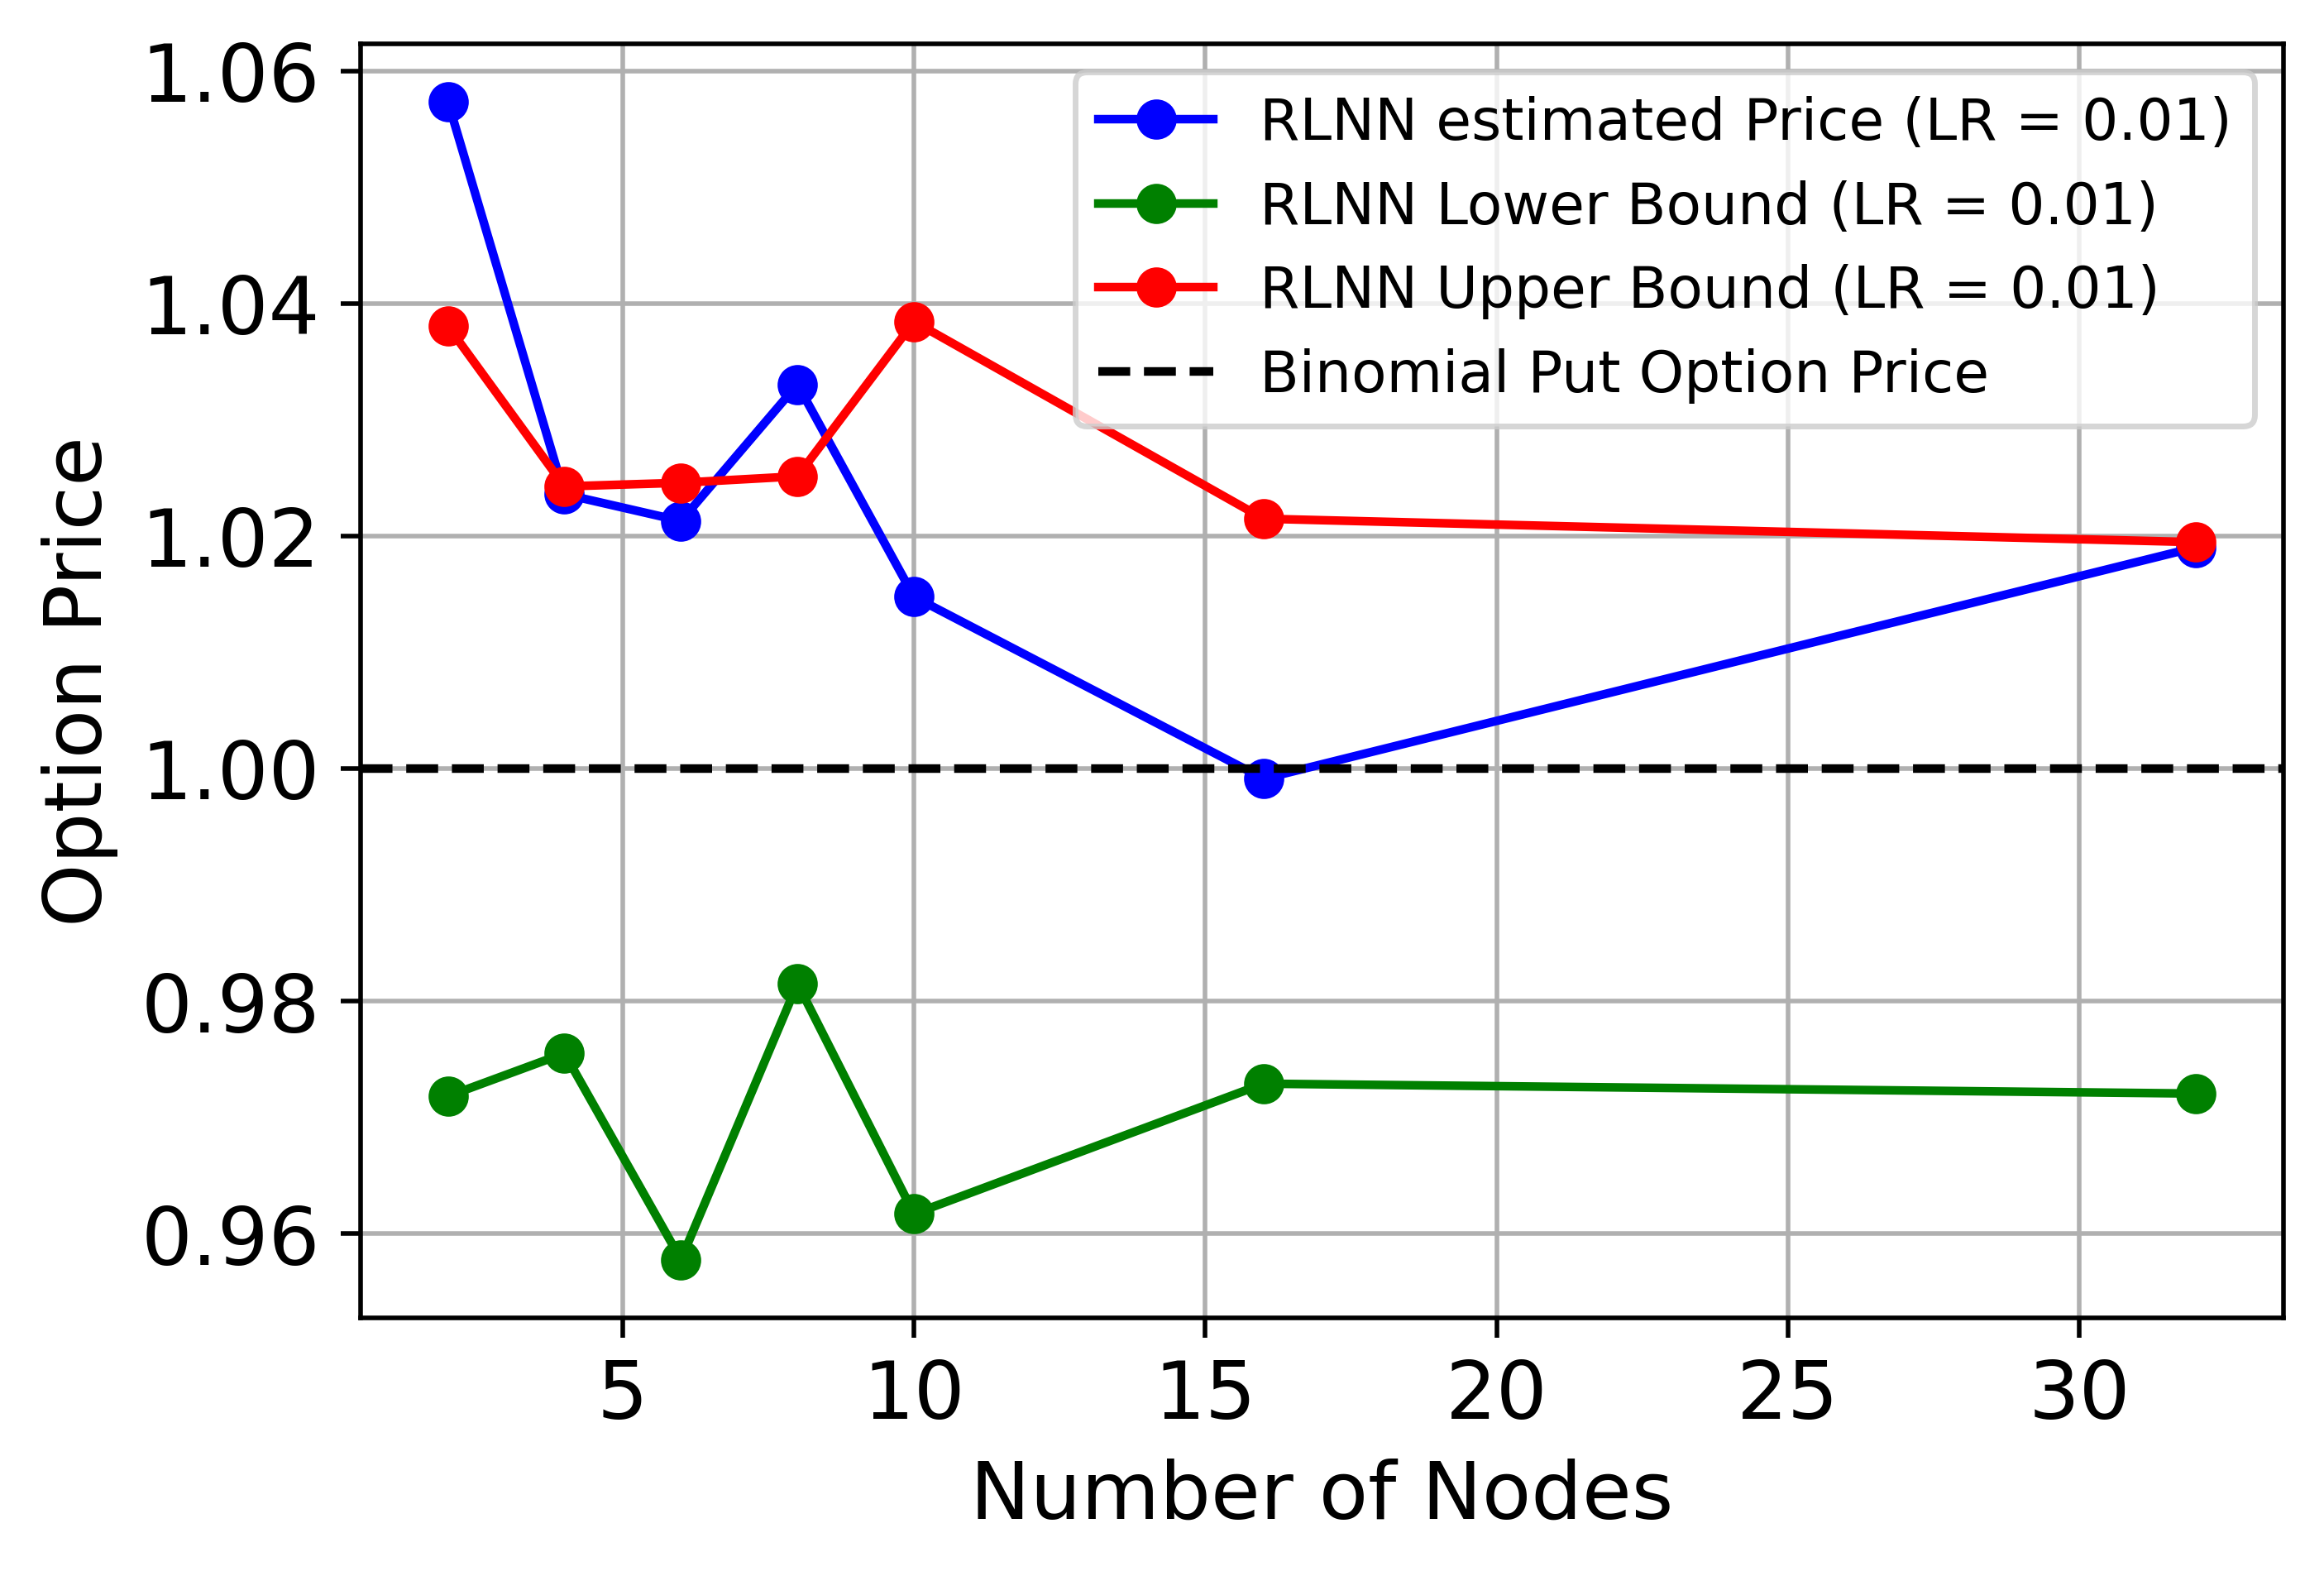

<Figure size 1000x600 with 0 Axes>

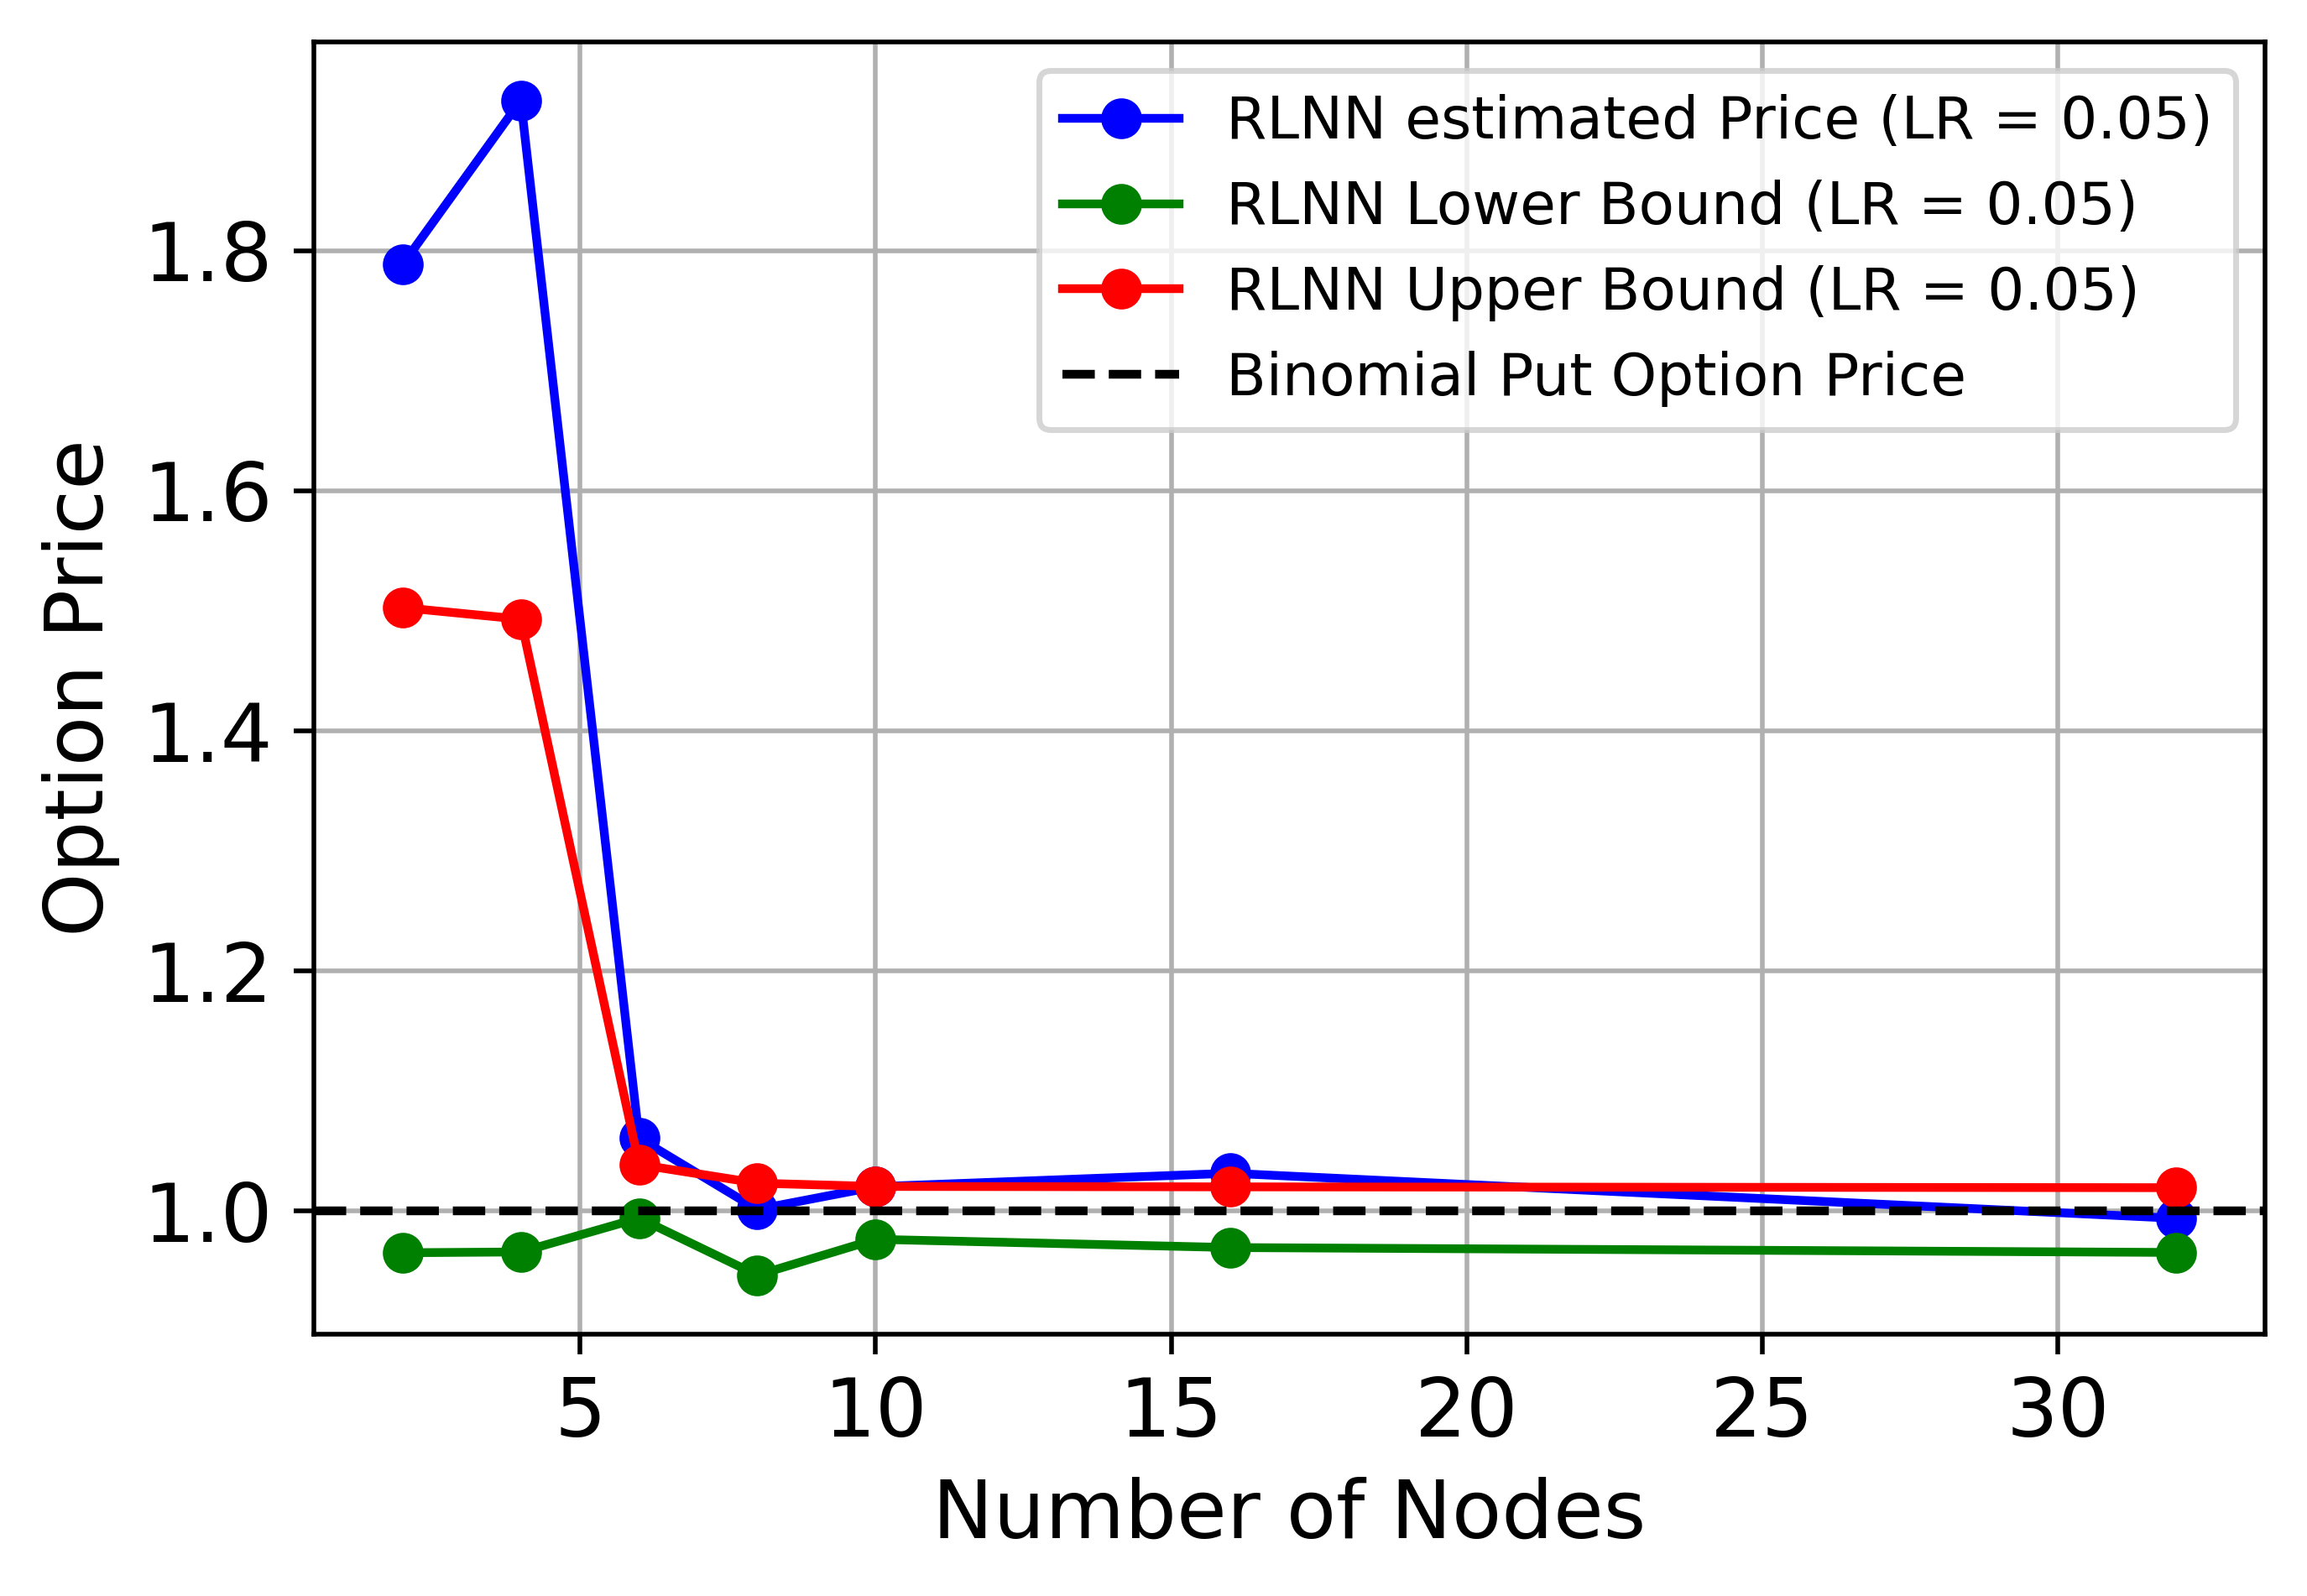

<Figure size 1000x600 with 0 Axes>

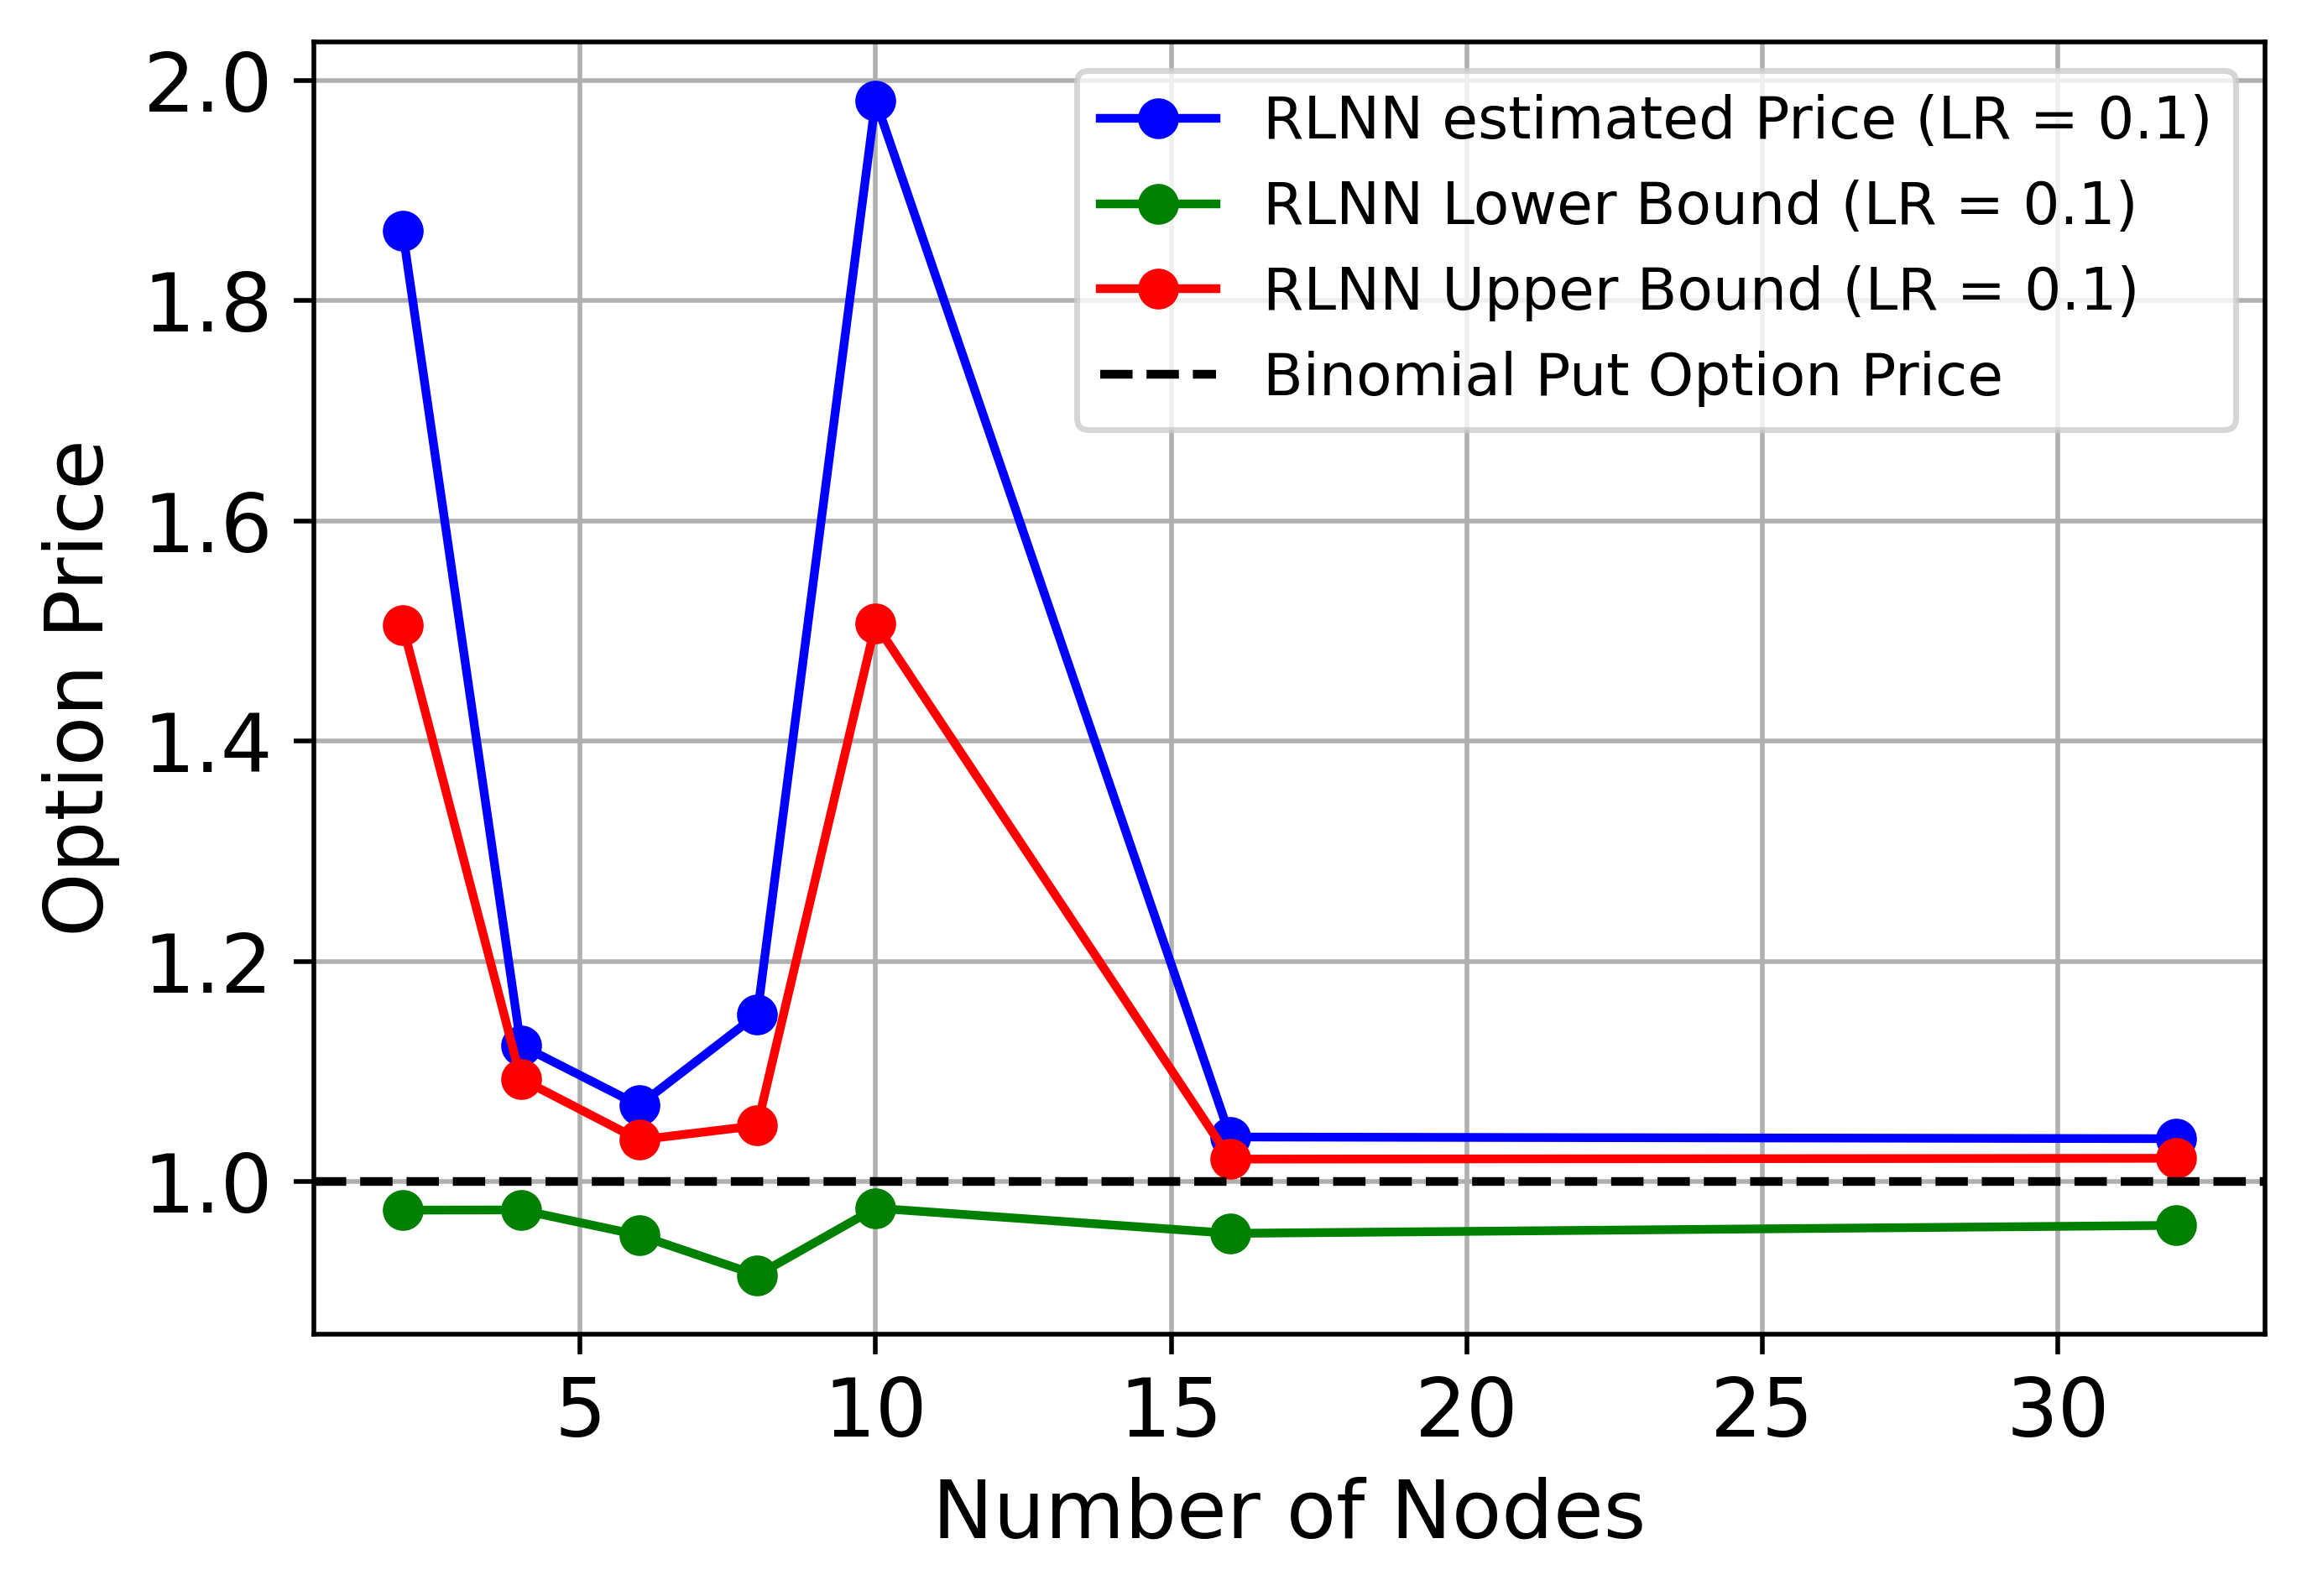

In [74]:
import json
import matplotlib.pyplot as plt

# Load results from JSON
input_file = "results_RLLN_different_nodes.json"
with open(input_file, "r") as f:
    results_RLLN = json.load(f)

# Define learning rates and hidden units list
learning_rates = [0.01, 0.05, 0.1]
hidden_units_list = [2, 4, 6, 8, 10, 16, 32]

# Generate plots for each learning rate
for learning_rate in learning_rates:
    plt.figure(figsize=(10, 6))
    
    # Initialize data lists for the plot
    option_prices = []
    lower_bounds = []
    upper_bounds = []

    # Extract data for the current learning rate
    for result in results_RLLN:
        hidden_units = result["hidden_units"]
        learning_rate_results = next(
            (lr_result for lr_result in result["results"] if lr_result["learning_rate"] == learning_rate),
            None
        )

        if learning_rate_results:
            option_prices.append(learning_rate_results["option_prices_nodes"][0])
            lower_bounds.append(learning_rate_results["lower_Nodes"][0])
            upper_bounds.append(learning_rate_results["upper_Nodes"][0])

    # Create the plot
    plt.figure(dpi=500, figsize=(6, 4))
    
    # Plot data
    plt.plot(hidden_units_list, option_prices, marker="o", label=f"RLNN estimated Price (LR = {learning_rate})", color="blue")
    plt.plot(hidden_units_list, lower_bounds, marker="o", label=f"RLNN Lower Bound (LR = {learning_rate})", color="green")
    plt.plot(hidden_units_list, upper_bounds, marker="o", label=f"RLNN Upper Bound (LR = {learning_rate})", color="red")

    # Add a reference line for Binomial Put Option Price
    binomial_price = 1.0  # Replace with actual value if known
    plt.axhline(y=binomial_price, color="black", linestyle="--", label="Binomial Put Option Price")

    # Customize plot
    plt.xlabel("Number of Nodes", fontsize=14)  # Larger font for axes
    plt.ylabel("Option Price", fontsize=14)    # Larger font for axes
    plt.legend(fontsize=10)  # Smaller font for legend
    plt.grid(True)

    # Save or show plot
    plt.savefig(f"rlnn_option_pricing_lr_{learning_rate}.png")
    plt.show()


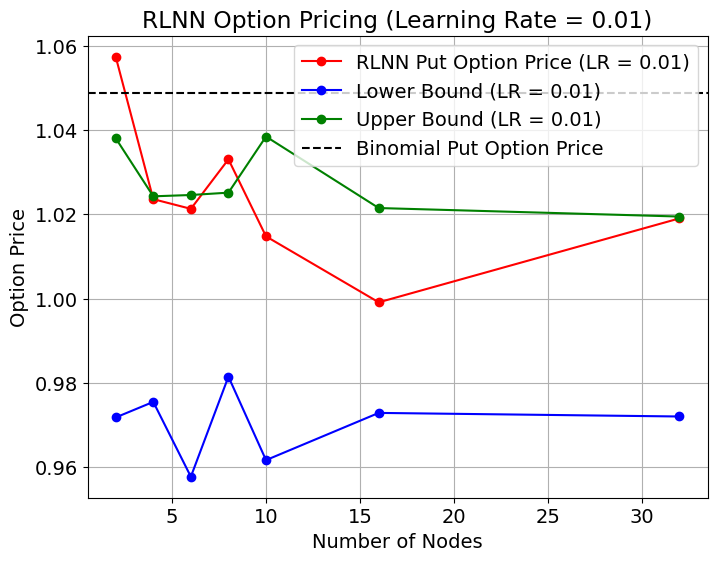

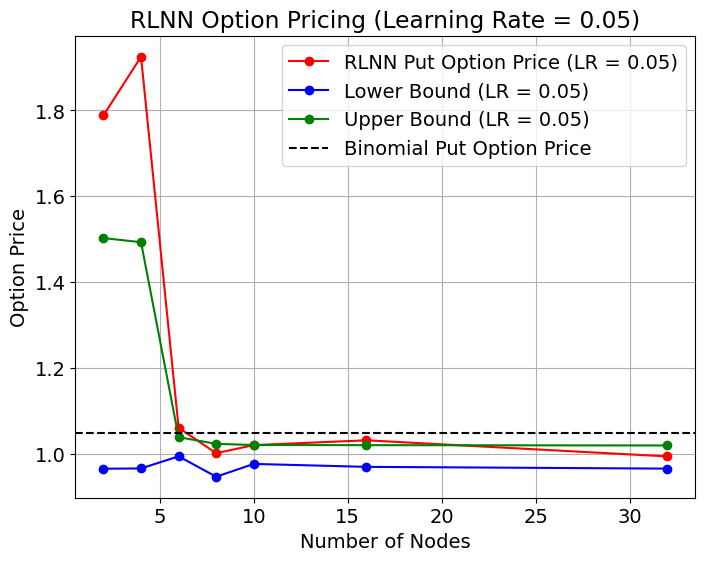

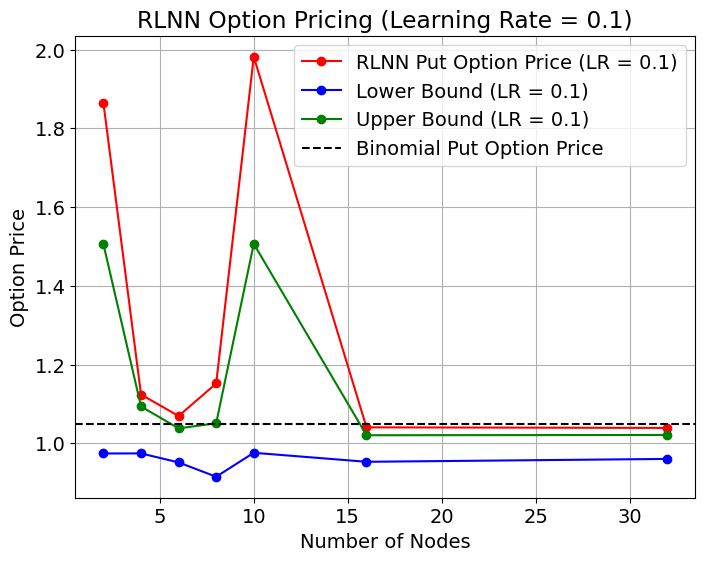

In [76]:
def plot_rlnn_results_with_nodes(results, nodes, S0, K, T, r, N, exercise_dates, option_type="put"):
    """
    Create separate plots for RLNN results with nodes as the x-axis for a fixed volatility.
    
    Parameters:
    - results: List of dictionaries containing RLNN results for each node count.
    - nodes: List of node counts used in the experiment.
    - S0: Initial stock price.
    - K: Strike price.
    - T: Time to maturity.
    - r: Risk-free interest rate.
    - N: Number of steps for the binomial method.
    - exercise_dates: List of Bermudan option exercise dates.
    - option_type: Type of the option ("call" or "put").
    """
    # Loop through learning rates in the results
    for learning_rate in results[0]["results"]:
        ler_rate = learning_rate["learning_rate"]

        option_prices = []
        lower_bounds = []
        upper_bounds = []

        for result in results:
            # Get the corresponding result for this learning rate
            lr_results = next((r for r in result["results"] if r["learning_rate"] == ler_rate), None)
            if lr_results:
                option_prices.append(np.mean(lr_results["option_prices_nodes"]))
                lower_bounds.append(np.mean(lr_results["lower_Nodes"]))
                upper_bounds.append(np.mean(lr_results["upper_Nodes"]))

        # Calculate the binomial price for comparison
        binomial_price = bermudan_option_binomial(S0, K, T, r, volatility, N, exercise_dates, option_type)

        # Plot the results
        plt.figure(figsize=(8, 6))
        plt.plot(nodes, option_prices, label=f'RLNN Put Option Price (LR = {ler_rate})', marker='o', color='r')
        plt.plot(nodes, lower_bounds, label=f'Lower Bound (LR = {ler_rate})', marker='o', color='b')
        plt.plot(nodes, upper_bounds, label=f'Upper Bound (LR = {ler_rate})', marker='o', color='g')
        plt.axhline(y=binomial_price, label='Binomial Put Option Price', color='black', linestyle='--')
        plt.xlabel('Number of Nodes')
        plt.ylabel('Option Price')
        plt.title(f"RLNN Option Pricing (Learning Rate = {ler_rate})")
        plt.legend()
        plt.grid()
        plt.show()

# Example usage
S0 = 50  # Initial stock price
K = 50   # Strike price
T = 1    # Time to maturity
r = 0.06  # Risk-free interest rate
N = 100  # Number of steps in the binomial tree
exercise_dates = [0.25, 0.5, 0.75, 1]  # Bermudan option exercise dates
nodes = [2, 4, 6, 8, 10, 16, 32]  # Node counts used in the experiment

plot_rlnn_results_with_nodes(results_RLLN, nodes, S0, K, T, r, N, exercise_dates, option_type="put")

In [92]:
# Parameters
volatilities = [0.05, 0.1, 0.2, 0.4, 0.6]  # Different volatilities to test
learning_rate = 0.05  # Fixed learning rate
no_hidden_units = 16  # Fixed number of nodes
results_RLLN = []

# Progress bar for volatilities
for volatility in tqdm(volatilities, desc="Volatilities", unit="vol"):
    try:
        option_prices_vol = []
        lower_Vol = []
        upper_Vol = []
        times_upper = []
        times_lower = []
        times_option = []

        # Parameters for simulation
        N_L = 20000
        S0 = 50
        K = 50
        mu = 0.06
        T = 1
        N = 4
        M = 1500

        # RLNN simulation
        start_time1 = time.time()
        option_price, trained_weights, error, paths = RLNN_Algo(S0, K, mu, volatility, M, N, T, 'put', no_hidden_units, learning_rate)
        end_time1 = time.time()
        option_prices_vol.append(option_price)
        times_option.append(end_time1 - start_time1)

        # Stock path simulation
        stock_paths = stock_price_simulator(S0, mu, volatility, T, N, N_L)

        # Lower bound calculation
        start_time2 = time.time()
        lower_bound = calculate_lower_bound(stock_paths, K, mu, volatility, T, N, 'put', trained_weights, no_hidden_units)
        end_time2 = time.time()
        lower_Vol.append(lower_bound)
        times_lower.append(end_time2 - start_time2)

        # Upper bound calculation
        start_time3 = time.time()
        upper_bound1 = upper_bound(mu, volatility, trained_weights, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', no_hidden_units)
        end_time3 = time.time()
        upper_Vol.append(upper_bound1)
        times_upper.append(end_time3 - start_time3)

        # Collect results for this volatility
        results_RLLN.append({
            "volatility": volatility,
            "option_prices_vol": option_prices_vol,
            "lower_Vol": lower_Vol,
            "upper_Vol": upper_Vol,
            "times_option": times_option,
            "times_lower": times_lower,
            "times_upper": times_upper
        })
    except Exception as e:
        print(f"Error with volatility {volatility}: {e}")
        continue

# Save results to JSON
output_file = "results_RLLN_fixed_nodes_lr.json"
with open(output_file, "w") as f:
    json.dump(results_RLLN, f, indent=4)

print(f"Simulation completed. Results saved to {output_file}.")


Volatilities:   0%|          | 0/5 [00:00<?, ?vol/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_34008\4207864000.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


Volatilities:  20%|██        | 1/5 [01:36<06:25, 96.27s/vol]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Volatilities:  40%|████      | 2/5 [03:21<05:04, 101.47s/vol]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


Volatilities:  60%|██████    | 3/5 [04:48<03:09, 94.88s/vol] 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


Volatilities:  80%|████████  | 4/5 [05:58<01:25, 85.02s/vol]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Volatilities: 100%|██████████| 5/5 [07:32<00:00, 90.51s/vol]

Simulation completed. Results saved to results_RLLN_fixed_nodes_lr.json.


In [93]:
with open(output_file, "w") as f:
    json.dump(results_RLLN, f, indent=4)

print(f"Simulation completed. Results saved to {output_file}.")

Simulation completed. Results saved to results_RLLN_fixed_nodes_lr.json.


In [94]:
results_RLLN

[{'volatility': 0.05,
  'option_prices_vol': [np.float64(0.5189867753152175)],
  'lower_Vol': [np.float64(0.28214496605584566)],
  'upper_Vol': [np.float64(0.3994444971825854)],
  'times_option': [54.579002141952515],
  'times_lower': [18.177366495132446],
  'times_upper': [23.502192974090576]},
 {'volatility': 0.1,
  'option_prices_vol': [np.float64(1.0241015282583732)],
  'lower_Vol': [np.float64(0.9567620577048792)],
  'upper_Vol': [np.float64(1.019977682883947)],
  'times_option': [46.27373790740967],
  'times_lower': [24.38938546180725],
  'times_upper': [34.445000648498535]},
 {'volatility': 0.2,
  'option_prices_vol': [np.float64(2.749632036803974)],
  'lower_Vol': [np.float64(2.541915140383111)],
  'upper_Vol': [np.float64(2.7292298968336866)],
  'times_option': [46.786858797073364],
  'times_lower': [16.989534378051758],
  'times_upper': [23.26572036743164]},
 {'volatility': 0.4,
  'option_prices_vol': [np.float64(6.245099240697004)],
  'lower_Vol': [np.float64(5.8366743277791

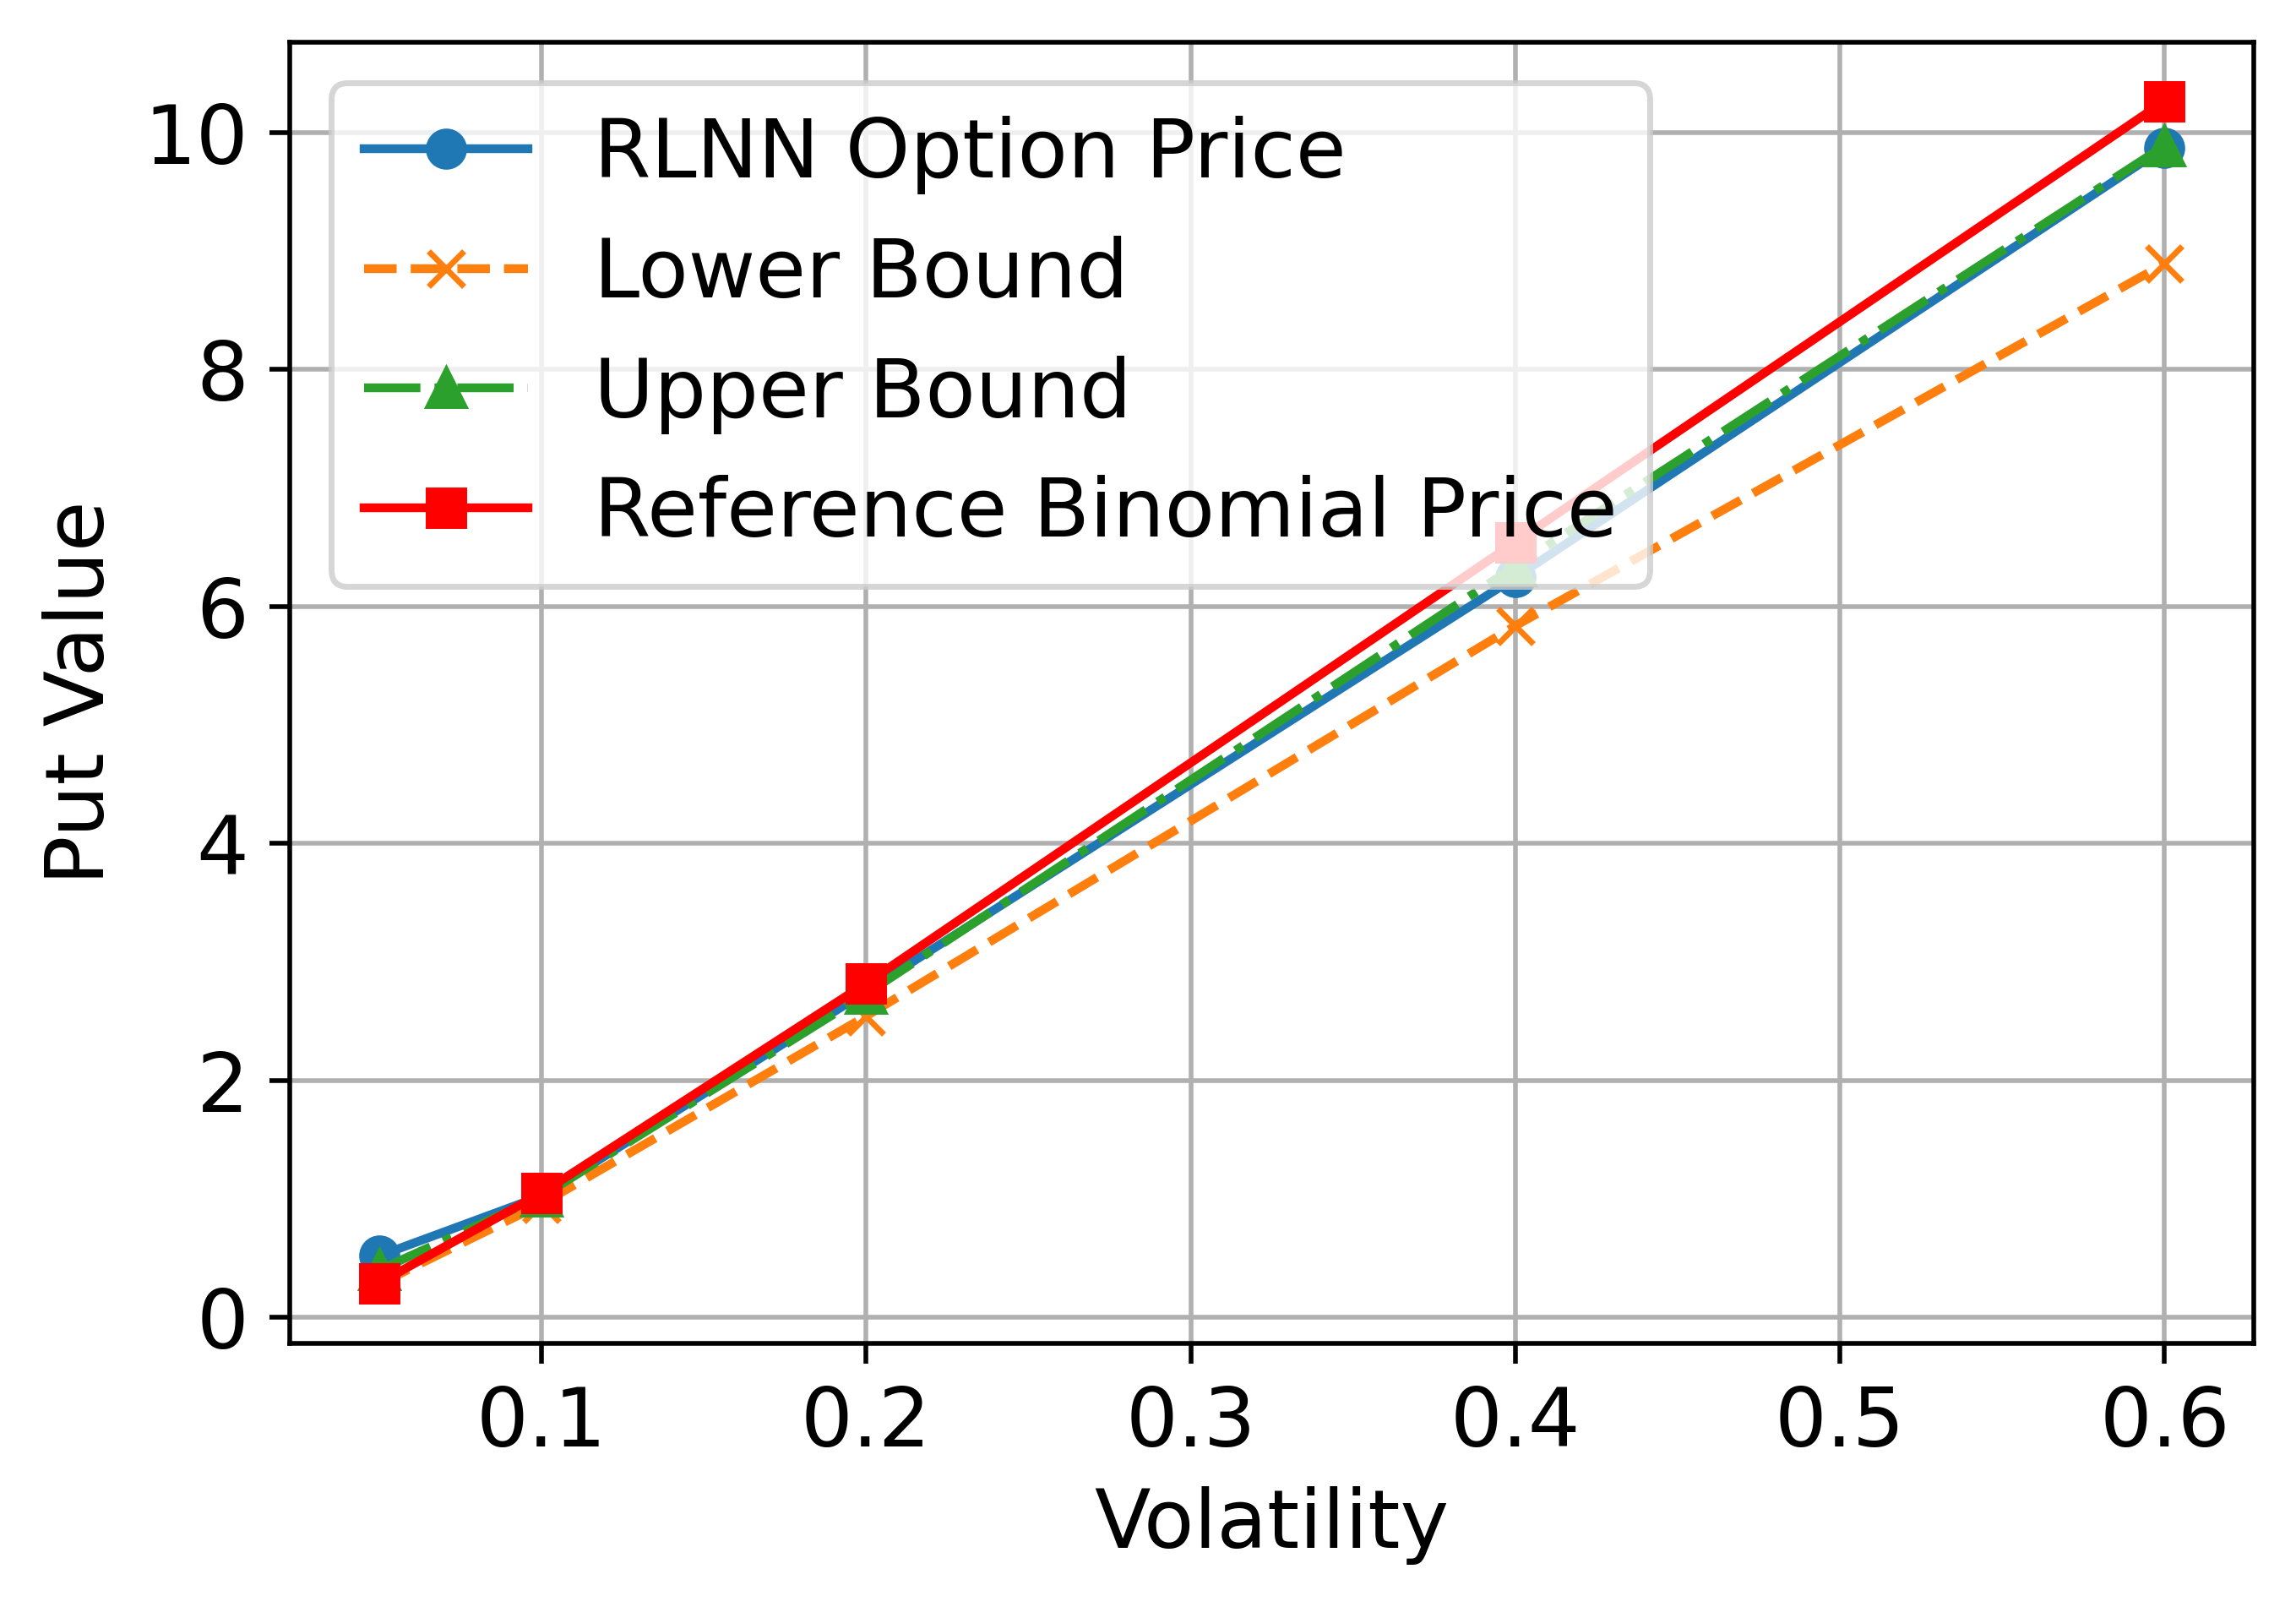

In [95]:
import matplotlib.pyplot as plt
import numpy as np


# Extract data for plotting
volatilities = []
option_prices = []
lower_bounds = []
upper_bounds = []
reference_prices = []

for result in results_RLLN:
    vol = result["volatility"]
    prices = result["option_prices_vol"]
    lowers = result["lower_Vol"]
    uppers = result["upper_Vol"]

    # Reference price: Replace this with your binomial implementation
    ref_price = bermudan_option_binomial(S0=50, K=50, T=1, r=0.06, sigma=vol, N=100,exercise_dates = [0.25, 0.5, 0.75, 1],  option_type='put')

    # Use the first value if lists are not empty (or take the average)
    volatilities.append(vol)
    option_prices.append(np.mean(prices) if prices else None)
    lower_bounds.append(np.mean(lowers) if lowers else None)
    upper_bounds.append(np.mean(uppers) if uppers else None)
    reference_prices.append(ref_price)

# Plotting

plt.figure(dpi=500, figsize=(6, 4))
plt.rc('font', size=14)
plt.plot(volatilities, option_prices, marker='o', linestyle='-', label="RLNN Option Price")
plt.plot(volatilities, lower_bounds, marker='x', linestyle='--', label="Lower Bound")
plt.plot(volatilities, upper_bounds, marker='^', linestyle='-.', label="Upper Bound")
plt.plot(volatilities, reference_prices, marker='s', linestyle='-', label="Reference Binomial Price", color='red')
plt.xlabel("Volatility")
plt.ylabel("Put Value")
# plt.title("Put Price, Bounds vs. Volatility")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()


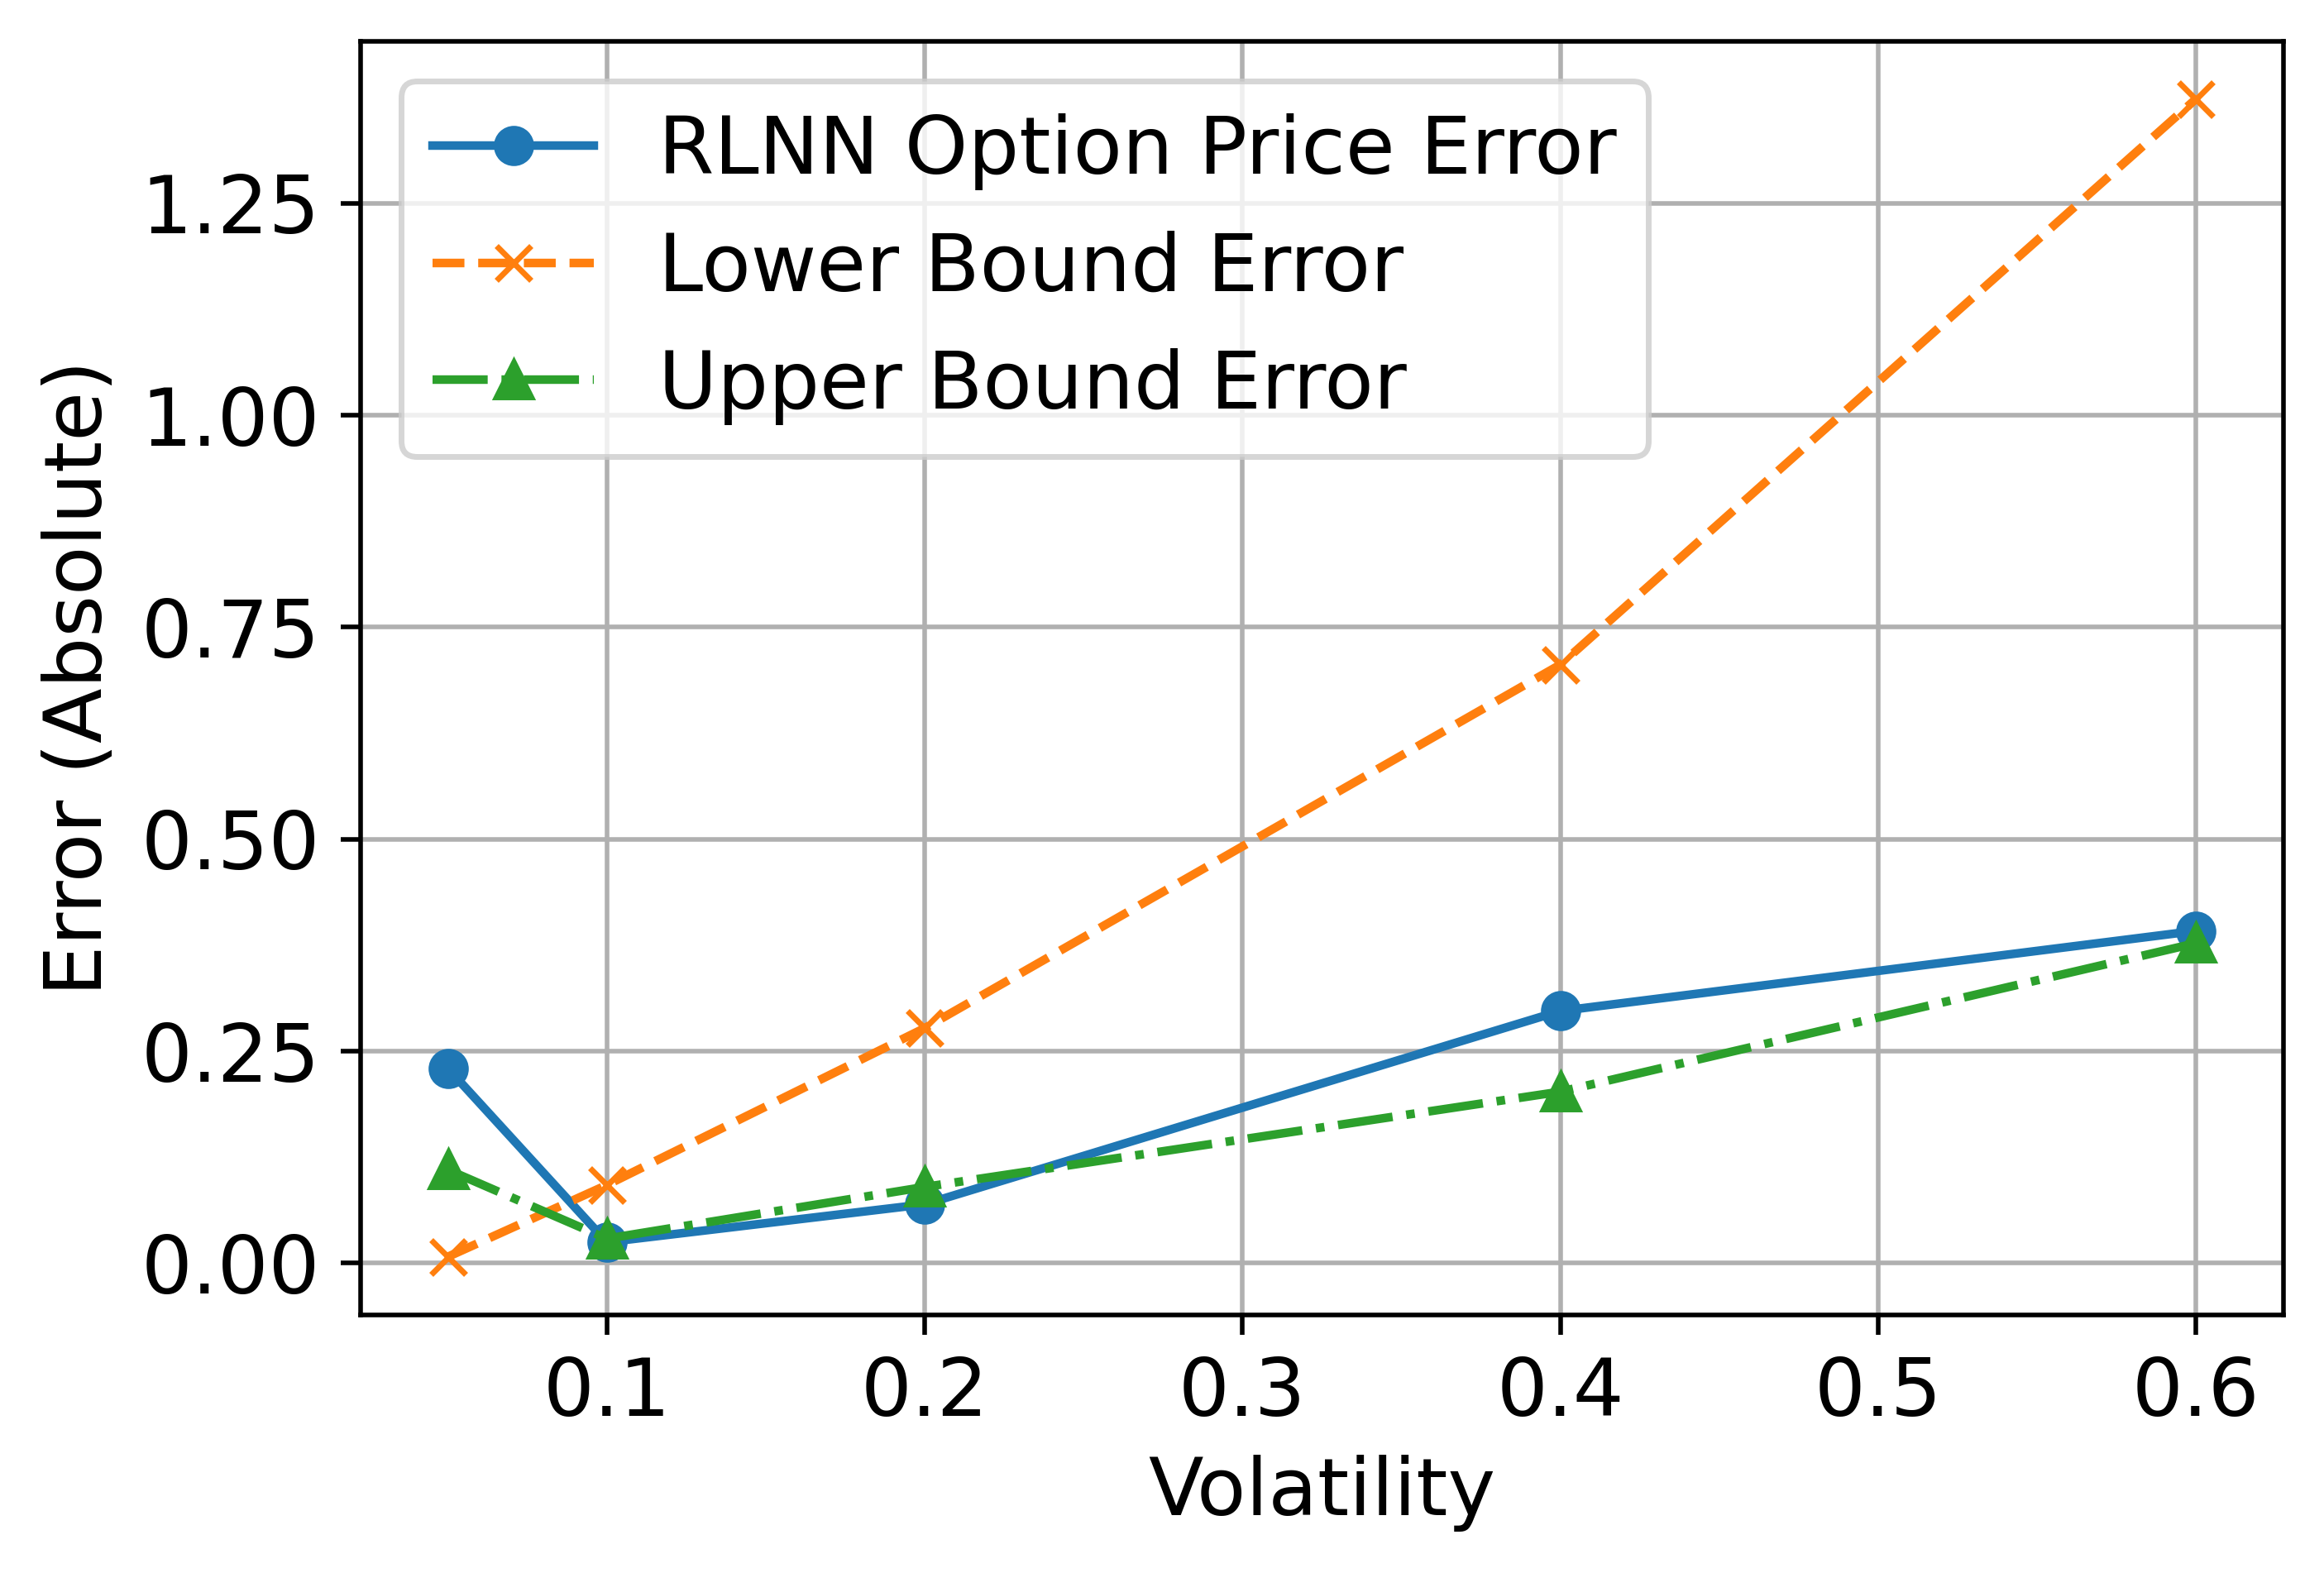

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for error computation
volatilities = []
option_prices = []
lower_bounds = []
upper_bounds = []
reference_prices = []
option_price_errors = []
lower_bound_errors = []
upper_bound_errors = []

for result in results_RLLN:
    vol = result["volatility"]
    prices = result["option_prices_vol"]
    lowers = result["lower_Vol"]
    uppers = result["upper_Vol"]

    # Reference price: Replace this with your binomial implementation
    ref_price = bermudan_option_binomial(S0=50, K=50, T=1, r=0.06, sigma=vol, N=100,exercise_dates = [0.25, 0.5, 0.75, 1],  option_type='put')

    # Use the first value if lists are not empty (or take the average)
    volatilities.append(vol)
    avg_option_price = np.mean(prices) if prices else None
    avg_lower_bound = np.mean(lowers) if lowers else None
    avg_upper_bound = np.mean(uppers) if uppers else None

    if avg_option_price is not None:
        option_prices.append(avg_option_price)
        lower_bounds.append(avg_lower_bound)
        upper_bounds.append(avg_upper_bound)
        reference_prices.append(ref_price)

        # Compute absolute errors
        option_price_errors.append(abs(avg_option_price - ref_price))
        lower_bound_errors.append(abs(avg_lower_bound - ref_price))
        upper_bound_errors.append(abs(avg_upper_bound - ref_price))

# Plotting
plt.figure(dpi=500, figsize=(6, 4))
plt.rc('font', size=14)
plt.plot(volatilities, option_price_errors, marker='o', linestyle='-', label="RLNN Option Price Error")
plt.plot(volatilities, lower_bound_errors, marker='x', linestyle='--', label="Lower Bound Error")
plt.plot(volatilities, upper_bound_errors, marker='^', linestyle='-.', label="Upper Bound Error")
plt.xlabel("Volatility")
plt.ylabel("Error (Absolute)")
# plt.title("Error vs. Binomial Price as a Function of Volatility")
plt.grid(True)
plt.legend()
plt.show()


In [98]:
result2 = pd.DataFrame({'Hidden Units': no_hidden_units, 'Option Price': option_prices_nodes, 
                       'Lower Bound': lower_Nodes, 'Upper Bound': upper_Nodes, 'Option Time': times_option, 
                       'Lower Bound Time': times_lower, 'Upper Bound Time': times_upper})
result2.to_csv('Results50000_10000.csv', index=False)

In [101]:
result2

,Hidden Units,Option Price,Lower Bound,Upper Bound,Option Time,Lower Bound Time,Upper Bound Time
0,16,1.038959,0.960234,1.021157,48.535115,18.97584,26.719383
